In [2]:
import numpy as np 
import pymultinest as pmn
import bagpipes as pipes
from astropy.table import Table
from astropy.io import ascii, fits
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
import matplotlib

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=20), plt.rc('ytick', labelsize=20)
plt.rcParams['savefig.dpi'] = 300
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

In [3]:
def Jy2ab(flux):
    return 2.5*(23-np.log10(flux))-48.6

def ab2Jy(mag):
    return 10**(23-(mag+48.6)/2.5)

def aberr2Jy(mag,magerr):
    return 5811.33*np.e**(-0.921034*mag)*magerr

def Jyerr2ab(flux, fluxerr):
    return 1.08574/flux*fluxerr

### load filter curves

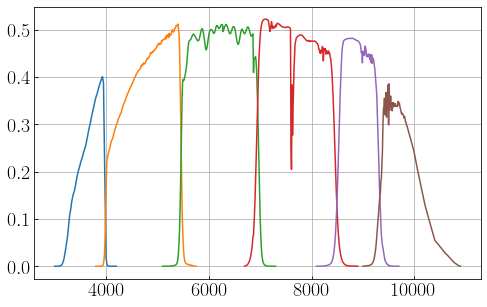

In [4]:
#clauds/hsc filter curves 
curve_u = 'hsc_responses_all_rev3/U.MP9302.txt'
curve_g = 'hsc_responses_all_rev3/hsc_g_v2018.dat'
curve_r = 'hsc_responses_all_rev3/hsc_r_v2018.dat'
curve_i = 'hsc_responses_all_rev3/hsc_i_v2018.dat'
curve_z = 'hsc_responses_all_rev3/hsc_z_v2018.dat'
curve_y = 'hsc_responses_all_rev3/hsc_y_v2018.dat'

#plot with new u_band
# curve_u = 'hsc_responses_all_rev3/cfh9301_norm.txt'
filt_list = [curve_u,curve_g,curve_r,curve_i,curve_z,curve_y]
plt.figure(figsize = (8, 5))
for filt in filt_list:
    fi = ascii.read(filt)
    plt.plot(fi['col1'], fi['col2'], '-')
plt.grid()
plt.show()


[SVO Filter Profile Service](http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php)

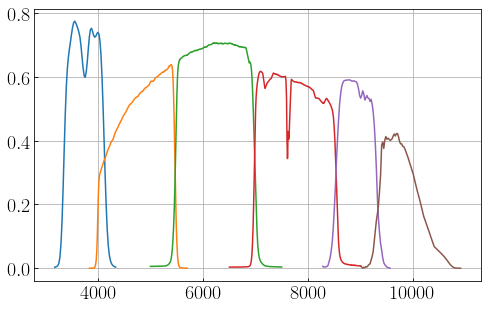

In [5]:
# redefine filt_list (from SVO)  and plot
curve_u = 'filters_new/CFHT_Megaprime.u.txt'
curve_g = 'filters_new/Subaru_HSC.g.txt'
curve_r = 'filters_new/Subaru_HSC.r.txt'
curve_i = 'filters_new/Subaru_HSC.i.txt'
curve_z = 'filters_new/Subaru_HSC.z.txt'
curve_y = 'filters_new/Subaru_HSC.Y.txt'
filt_list_new = [curve_u,curve_g,curve_r,curve_i,curve_z,curve_y]

plt.figure(figsize = (8, 5))
for filt in filt_list_new:
    fi = ascii.read(filt)
    plt.plot(fi['col1'], fi['col2'], '-')
plt.grid()
plt.show()


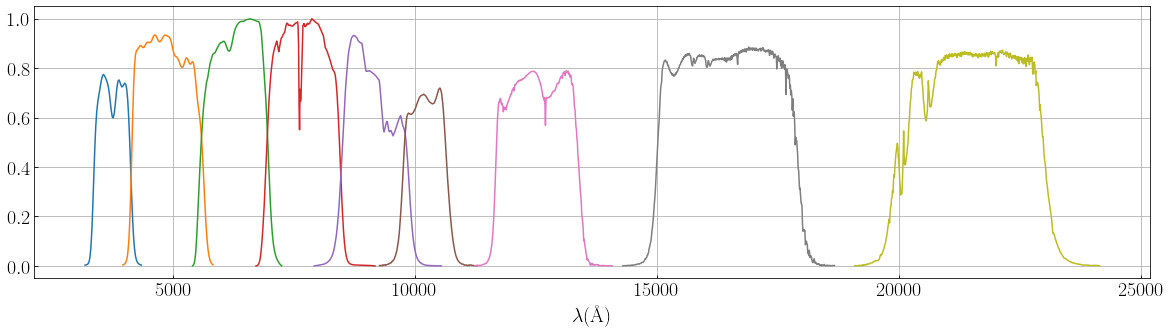

In [5]:
obsfilters_broadband = ["candels_pipes_test/obs_filters/CFHT_Megaprime_u.txt",
                        "candels_pipes_test/obs_filters/CFHT_Megaprime_g.txt",
#                         "candels_pipes_test/obs_filters/CFHT_Megaprime_r.txt",
#                         "candels_pipes_test/obs_filters/CFHT_Megaprime_i.txt",
#                         "candels_pipes_test/obs_filters/CFHT_Megaprime_z.txt",
#                         "candels_pipes_test/obs_filters/Subaru_Suprime_B.txt",
#                         "candels_pipes_test/obs_filters/Subaru_Suprime_g+.txt",
#                         "candels_pipes_test/obs_filters/Subaru_Suprime_V.txt",
                        "candels_pipes_test/obs_filters/Subaru_Suprime_r+.txt",
                        "candels_pipes_test/obs_filters/Subaru_Suprime_i+.txt",
                        "candels_pipes_test/obs_filters/Subaru_Suprime_z+.txt",
#                         "candels_pipes_test/obs_filters/HST_ACS_F606W.txt",
#                         "candels_pipes_test/obs_filters/HST_ACS_F814W.txt",
#                         "candels_pipes_test/obs_filters/HST_WFC3_F125W.txt",
#                         "candels_pipes_test/obs_filters/HST_WFC3_F160W.txt",
                        "candels_pipes_test/obs_filters/VISTA_Y.txt",
                        "candels_pipes_test/obs_filters/VISTA_J.txt",
                        "candels_pipes_test/obs_filters/VISTA_H.txt",
                        "candels_pipes_test/obs_filters/VISTA_Ks.txt"]

plt.figure(figsize = (20, 5))
for filt in obsfilters_broadband:
    fi = ascii.read(filt)
    plt.plot(fi['col1'], fi['col2'], '-')
    
plt.xlabel(r'$\lambda (\mathrm{\AA})$', fontsize=20)
plt.grid()
plt.show()




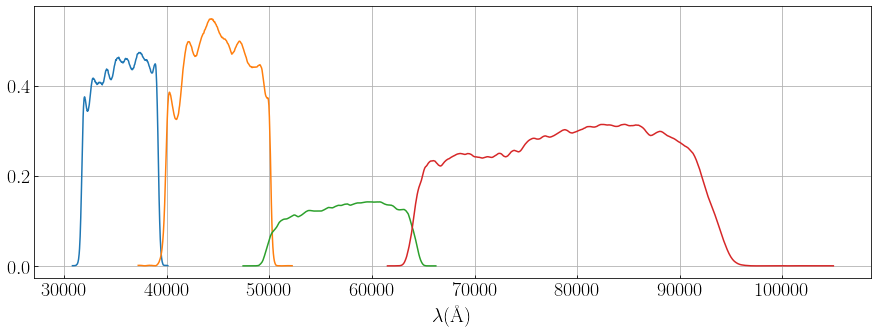

In [7]:
obsfilters_broadband = ["candels_pipes_test/obs_filters/IRAC_1.txt",
                        "candels_pipes_test/obs_filters/IRAC_2.txt",
                        "candels_pipes_test/obs_filters/IRAC_3.txt",
                        "candels_pipes_test/obs_filters/IRAC_4.txt"]

plt.figure(figsize = (15, 5))
for filt in obsfilters_broadband:
    fi = ascii.read(filt)
    plt.plot(fi['col1'], fi['col2'], '-')
    
plt.xlabel(r'$\lambda (\mathrm{\AA})$', fontsize=20)
plt.grid()
plt.show()


### make model galaxy (from example1)

In [8]:
# exp = {}                          # Tau model star formation history component
# exp["age"] = 5.                   # Gyr
# exp["tau"] = 0.75                 # Gyr
# exp["massformed"] = 9.            # log_10(M*/M_solar)
# exp["metallicity"] = 0.5          # Z/Z_oldsolar

delayed = {}
delayed["age"] = 5
delayed["tau"] = 1
delayed["massformed"] = 9             
delayed["metallicity"] = 1

dust = {}                         # Dust component
dust["type"] = "Calzetti"         # Define the shape of the attenuation curve
dust["Av"] = 0.2                  # magnitudes

model_components = {}                   # The model components dictionary
model_components["redshift"] = 0.4      # Observed redshift  
model_components["delayed"] = delayed 
model_components["dust"] = dust

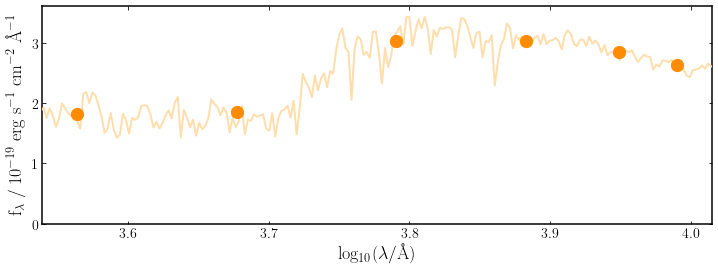

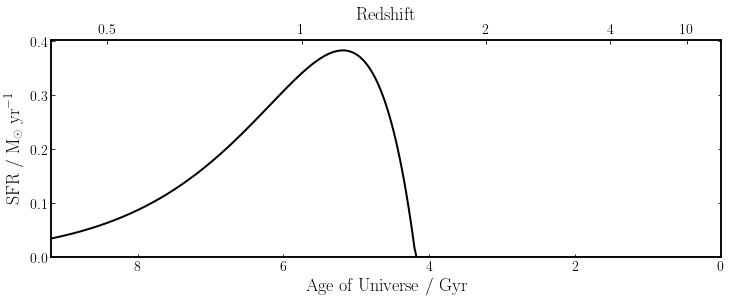

In [9]:
model = pipes.model_galaxy(model_components, filt_list=filt_list)
fig = model.plot()
fig = model.sfh.plot()

#### fit the model galaxy (check recovered parameters)

In [11]:
def load_from_model(ID):
    conversion = (10**-29*2.9979*10**18)/model.filter_set.eff_wavs**2
    fluxes = model.photometry/conversion
    fluxerrs = fluxes/10
    
    photometry = np.c_[fluxes, fluxerrs]
    return photometry


In [12]:
delayed = {}
delayed["age"] = (4.9, 5.1)
delayed["tau"] = (0.9, 1.1)
delayed["massformed"] = (8.9, 9.1)             
delayed["metallicity"] = (0.9, 1.1)

dust = {}                         # Dust component
dust["type"] = "Calzetti"         # Define the shape of the attenuation curve
dust["Av"] = (0.1, .3)                  # magnitudes

fit_instructions = {}                   # The model components dictionary
fit_instructions["redshift"] = (0., 1.)
# fit_instructions["redshift_prior"] = "Gaussian"
# fit_instructions["redshift_prior_mu"] = 0.4
# fit_instructions["redshift_prior_sigma"] =  0.05
fit_instructions["delayed"] = delayed 
fit_instructions["dust"] = dust

In [13]:
a = np.random.randint(10000)
print('v'+str(a))

galaxy = pipes.galaxy('test model', load_from_model, spectrum_exists=False, filt_list = filt_list)

fit = pipes.fit(galaxy, fit_instructions, run="v"+str(a))
fit.fit(verbose=True, n_live=200)


v9332

Bagpipes: fitting object test model


Completed in 4.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
delayed:age                    4.933      4.996      5.066
delayed:massformed             8.933      9.003      9.064
delayed:metallicity            0.930      0.996      1.068
delayed:tau                    0.950      1.003      1.059
dust:Av                        0.137      0.211      0.272
redshift                       0.378      0.401      0.425




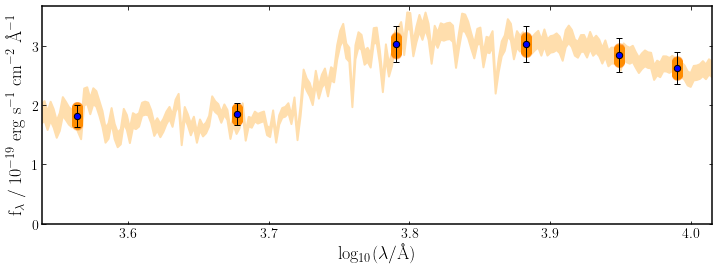

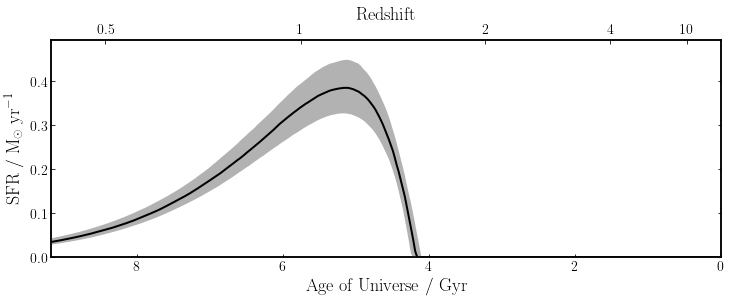

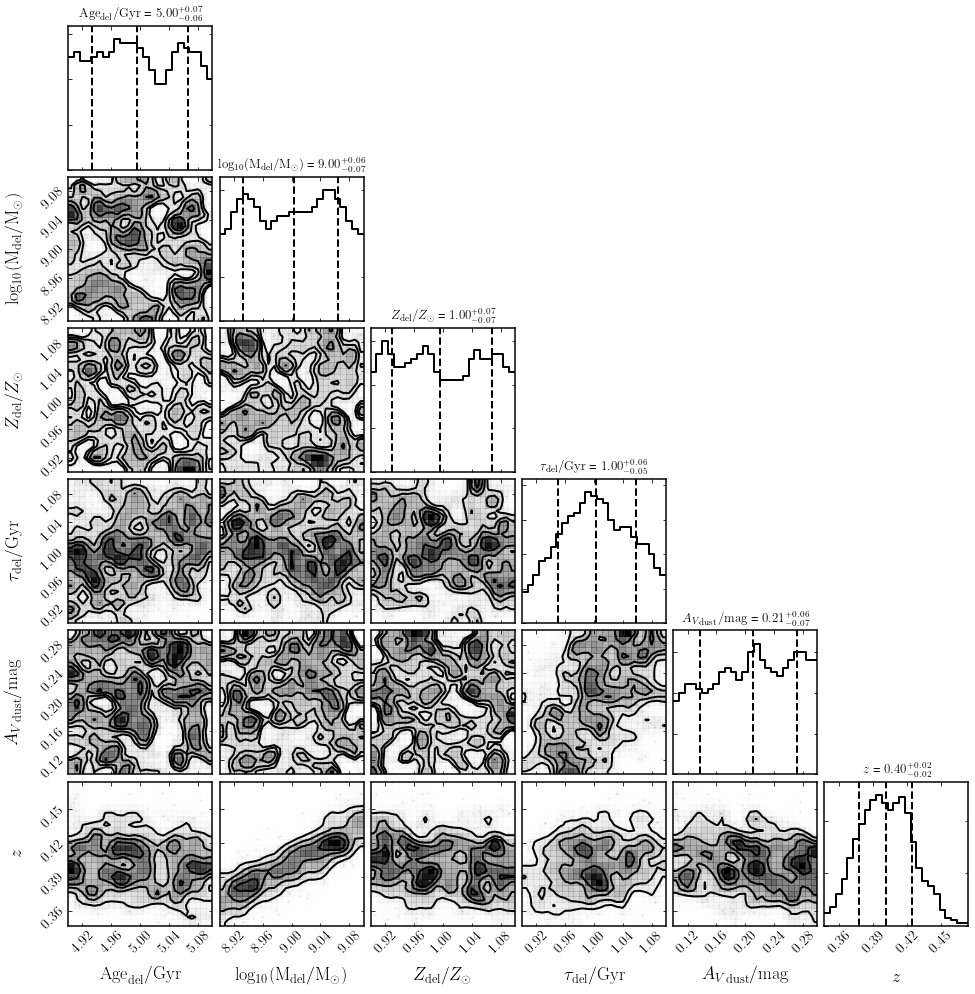

In [14]:
fig = fit.plot_spectrum_posterior(save=False, show=True)
fig = fit.plot_sfh_posterior(save=False, show=True)
fig = fit.plot_corner(save=False, show=True)

create model galaxy catalogs

In [3]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [4]:
def get_model_params(z, age, tau, mass, metallicity, Av):
    delayed = {}
    delayed["age"] = age
    delayed["tau"] = tau
    delayed["massformed"] = mass            
    delayed["metallicity"] = metallicity

    dust = {}                         # Dust component
    dust["type"] = "Calzetti"         # Define the shape of the attenuation curve
    dust["Av"] = Av                  # magnitudes
    
    model_components = {}                   # The model components dictionary
    model_components["redshift"] = z        # Observed redshift  
    model_components["delayed"] = delayed 
    model_components["dust"] = dust
    
    return model_components

In [17]:
n_gal = 10
z_list = 0.3 + 0.6*np.random.rand(n_gal)
tau_list = 0.1 + (3 - 0.1)*np.random.rand(n_gal)
mass_list = 7 + (14 - 7)*np.random.rand(n_gal)
metallicity_list  = 0.9 + (1.1 - 0.9)*np.random.rand(n_gal)
Av_list = 0.15 + (0.25 - 0.15)*np.random.rand(n_gal)

cat_data = np.array([])
for i in tqdm(range(len(z_list))):
    z = z_list[i]
    age = np.random.rand()*cosmo.age(z).value  # less than age of Universe at observed z (in Gyr)
    tau = tau_list[i] # in Gyr
    mass = mass_list[i] 
    metallicity = metallicity_list[i]
    Av = Av_list[i]
    
    sigma_z = 0.04*(1+z)
    model_components = get_model_params(z, age=age, tau=tau, mass=mass, metallicity=metallicity, Av=Av)
    model = pipes.model_galaxy(model_components, filt_list=filt_list)
    sfr = model.sfh.sfh[0]
    
    conversion = (10**-29*2.9979*10**18)/model.filter_set.eff_wavs**2 # from ergs/s/cm^2/angs to mJy
    fluxes = model.photometry/conversion/1e6 # in Jy
    fluxerrs = fluxes/5  # fixed SNR
    
    mags = Jy2ab(fluxes)
    magerrs = Jyerr2ab(fluxes, fluxerrs)
    
    row = np.array([int(i+1),z,sigma_z,age,tau,mass,metallicity, Av, sfr,
                    fluxes[0],fluxes[1],fluxes[2],fluxes[3],fluxes[4],fluxes[5],
                    fluxerrs[0],fluxerrs[1],fluxerrs[2],fluxerrs[3],fluxerrs[4],fluxerrs[5],
                    mags[0],mags[1],mags[2],mags[3],mags[4],mags[5],
                    magerrs[0],magerrs[1],magerrs[2],magerrs[3],magerrs[4],magerrs[5]])
    
    if i==0:
        cat_data = row
    else:
        cat_data = np.vstack((cat_data, row))

names = ['ID','z','z_sigma','age','tau','mass','metallicity', 'Av', 'sfr',
         'flux_u','flux_g','flux_r','flux_i','flux_z','flux_y',
         'fluxerr_u','fluxerr_g','fluxerr_r','fluxerr_i','fluxerr_z','fluxerr_y',
         'mag_u','mag_g','mag_r','mag_i','mag_z','mag_y',
         'magerr_u','magerr_g','magerr_r','magerr_i','magerr_z','magerr_y']

dtypes = ['i8']+['f8']*32
cat_model_gal = Table(cat_data, names=names, dtype=dtypes)
cat_model_gal.write('model_gals_bagpipes_10.fits', overwrite=True)

100%|██████████| 10/10 [00:01<00:00,  5.14it/s]


In [28]:
cat_model_pipes_added = Table.read('bagpipes_scripts/model_gals_bagpipes_100_pipes_added.fits')

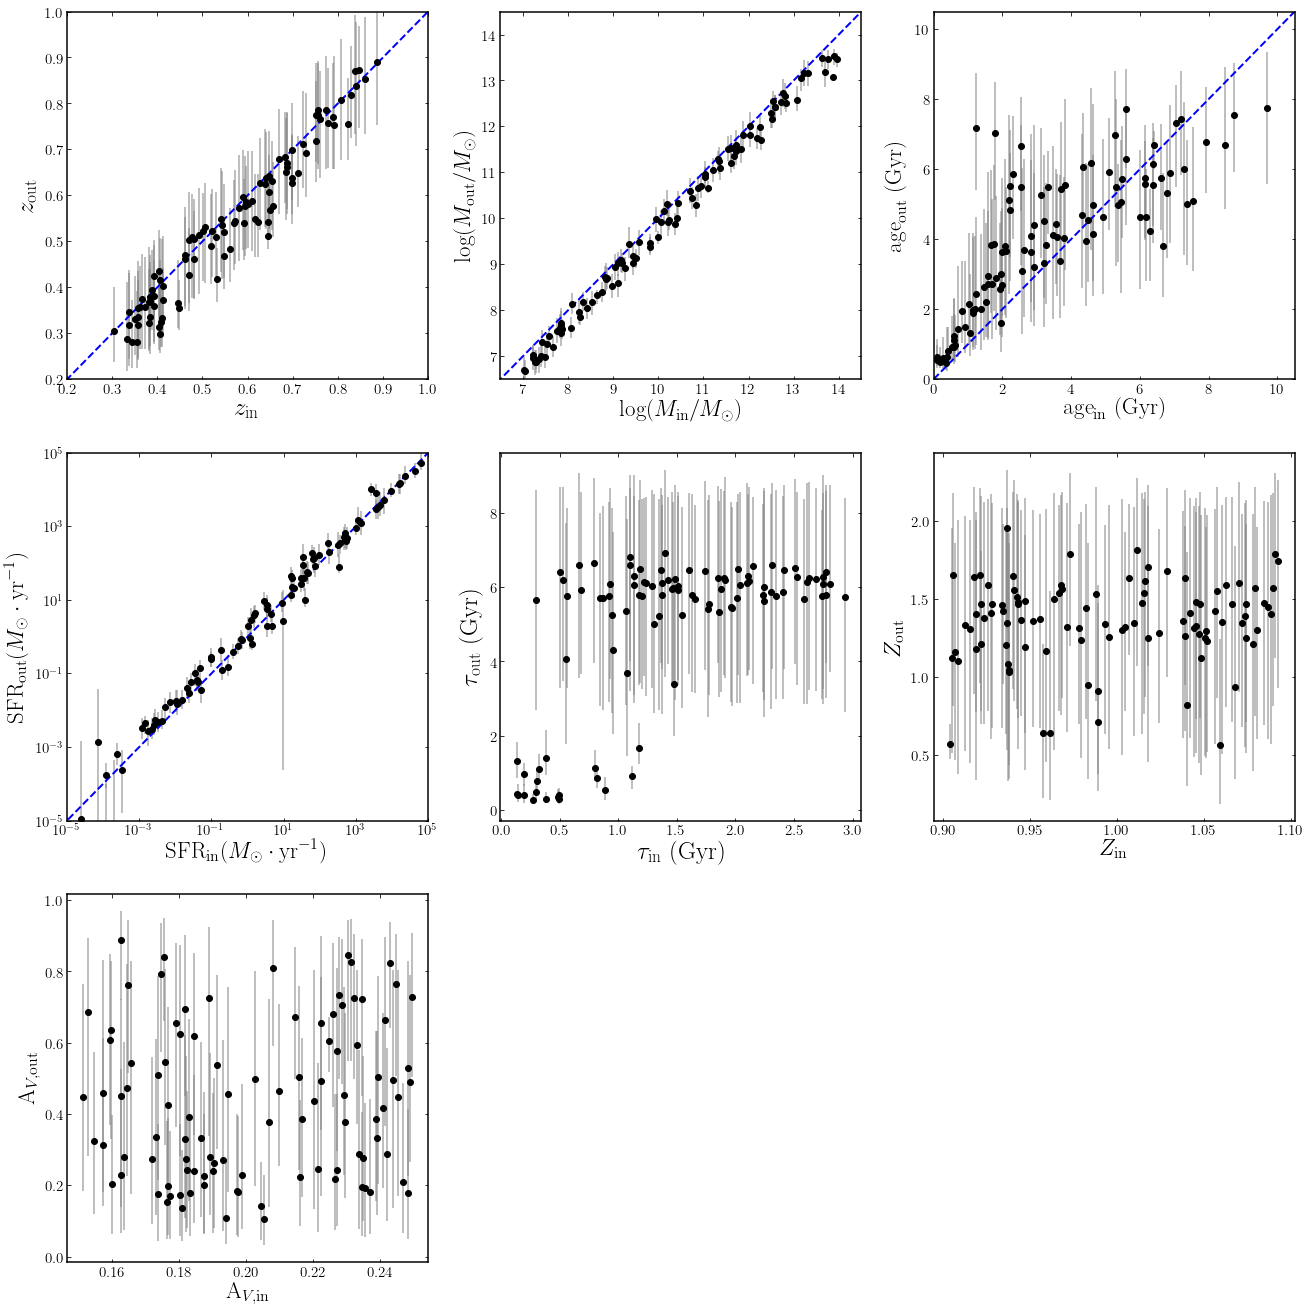

In [98]:
# z, mass, age, sfr, tau, metallicity, Av
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
fig, axs = plt.subplots(3, 3, figsize=(22,23))

# z
z_in = cat_model_pipes_added['z']
z_out = cat_model_pipes_added['redshift_50']
z_out_low = cat_model_pipes_added['redshift_16']
z_out_high = cat_model_pipes_added['redshift_84']

markers, caps, bars = axs[0][0].errorbar(z_in, z_out,
                                         yerr = [z_out - z_out_low,z_out_high-z_out],linestyle="None",
                                         fmt='ok',ecolor='gray')
[bar.set_alpha(0.5) for bar in bars]

axs[0][0].plot([0,1.5],[0,1.5],color='b',linestyle='--')
axs[0][0].set_xlim([0.2,1])
axs[0][0].set_ylim([0.2,1])
axs[0][0].set_xlabel(r'$z_\mathrm{in}$',fontsize=25)
axs[0][0].set_ylabel(r'$z_\mathrm{out}$',fontsize=25)

# mass
m_in = cat_model_pipes_added['mass']
m_out = cat_model_pipes_added['stellar_mass_50']
m_out_low = cat_model_pipes_added['stellar_mass_16']
m_out_high = cat_model_pipes_added['stellar_mass_84']

markers, caps, bars = axs[0][1].errorbar(m_in, m_out,
                                         yerr = [m_out - m_out_low,m_out_high-m_out],linestyle="None",
                                         fmt='ok',ecolor='gray')
[bar.set_alpha(0.5) for bar in bars]

axs[0][1].plot([0,15],[0,15],color='b',linestyle='--')
axs[0][1].set_xlim([6.5,14.5])
axs[0][1].set_ylim([6.5,14.5])
axs[0][1].set_xlabel(r'$\log (M_\mathrm{in}/M_\odot)$',fontsize=23)
axs[0][1].set_ylabel(r'$\log (M_\mathrm{out}/M_\odot)$',fontsize=23)

# age
age_in = cat_model_pipes_added['age']
age_out = cat_model_pipes_added['delayed:age_50']
age_out_low = cat_model_pipes_added['delayed:age_16']
age_out_high = cat_model_pipes_added['delayed:age_84']

markers, caps, bars = axs[0][2].errorbar(age_in, age_out, 
                                         yerr = [age_out - age_out_low,age_out_high-age_out],linestyle="None",
                                         fmt='ok',ecolor='gray')
[bar.set_alpha(0.5) for bar in bars]

axs[0][2].plot([0,11],[0,11],color='b',linestyle='--')
axs[0][2].set_xlim([0,10.5])
axs[0][2].set_ylim([0,10.5])
axs[0][2].set_xlabel(r'$\mathrm{age}_\mathrm{in}$ (Gyr)',fontsize=23)
axs[0][2].set_ylabel(r'$\mathrm{age}_\mathrm{out}$ (Gyr)',fontsize=23)

# sfr
sfr_in = cat_model_pipes_added['sfr']
sfr_out = cat_model_pipes_added['sfr_50']
sfr_out_low = cat_model_pipes_added['sfr_16']
sfr_out_high = cat_model_pipes_added['sfr_84']

markers, caps, bars = axs[1][0].errorbar(sfr_in, sfr_out, 
                                         yerr = [sfr_out - sfr_out_low,sfr_out_high-sfr_out],linestyle="None",
                                         fmt='ok',ecolor='gray')
[bar.set_alpha(0.5) for bar in bars]

axs[1][0].set_xscale('log')
axs[1][0].set_yscale('log')
axs[1][0].plot([1e-6,1e6],[1e-6,1e6],color='b',linestyle='--')
axs[1][0].set_xlim([1e-5,1e5])
axs[1][0].set_ylim([1e-5,1e5])
axs[1][0].set_xlabel(r'$\mathrm{SFR}_\mathrm{in} (M_\odot\cdot \mathrm{yr}^{-1})$',fontsize=23)
axs[1][0].set_ylabel(r'$\mathrm{SFR}_\mathrm{out} (M_\odot\cdot \mathrm{yr}^{-1})$',fontsize=23)

# tau
tau_in = cat_model_pipes_added['tau']
tau_out = cat_model_pipes_added['delayed:tau_50']
tau_out_low = cat_model_pipes_added['delayed:tau_16']
tau_out_high = cat_model_pipes_added['delayed:tau_84']

markers, caps, bars = axs[1][1].errorbar(tau_in, tau_out, 
                                         yerr = [tau_out - tau_out_low,tau_out_high-tau_out],linestyle="None",
                                         fmt='ok',ecolor='gray')
[bar.set_alpha(0.5) for bar in bars]

axs[1][1].set_xlabel(r'$\tau_\mathrm{in}$ (Gyr)',fontsize=25)
axs[1][1].set_ylabel(r'$\tau_\mathrm{out}$ (Gyr)',fontsize=25)

# metallicity
metal_in = cat_model_pipes_added['metallicity']
metal_out = cat_model_pipes_added['delayed:metallicity_50']
metal_out_low = cat_model_pipes_added['delayed:metallicity_16']
metal_out_high = cat_model_pipes_added['delayed:metallicity_84']

markers, caps, bars = axs[1][2].errorbar(metal_in, metal_out, 
                                         yerr = [metal_out - metal_out_low,metal_out_high-metal_out],linestyle="None",
                                         fmt='ok',ecolor='gray')
[bar.set_alpha(0.5) for bar in bars]

axs[1][2].set_xlabel(r'$Z_\mathrm{in}$',fontsize=23)
axs[1][2].set_ylabel(r'$Z_\mathrm{out}$',fontsize=23)

# Av
av_in = cat_model_pipes_added['Av']
av_out = cat_model_pipes_added['dust:Av_50']
av_out_low = cat_model_pipes_added['dust:Av_16']
av_out_high = cat_model_pipes_added['dust:Av_84']

markers, caps, bars = axs[2][0].errorbar(av_in, av_out, 
                                         yerr = [av_out - av_out_low, av_out_high-av_out],linestyle="None",
                                         fmt='ok',ecolor='gray')
[bar.set_alpha(0.5) for bar in bars]
axs[2][0].set_xlabel(r'$\mathrm{A}_{V,\mathrm{in}}$',fontsize=23)
axs[2][0].set_ylabel(r'$\mathrm{A}_{V,\mathrm{out}}$',fontsize=23)

fig.delaxes(axs[2][1])
fig.delaxes(axs[2][2])
plt.savefig('/Users/lejay/Desktop/model_pipes_compare.pdf')


### photometry data fit from CLAUDS

In [14]:
def load_gal(ID):
    cat = Table.read('CUT_deep_catalogs/cosmos_to_fit.fits')
    gal = cat[cat['ID']==ID]

    u, g, r, i, z, y = gal['MAG_APER_2s_u'], gal['MAG_APER_2s_g'], gal['MAG_APER_2s_r'], gal['MAG_APER_2s_i'], gal[
        'MAG_APER_2s_z'], gal['MAG_APER_2s_y']
    uerr, gerr, rerr, ierr, zerr, yerr = gal['MAGERR_APER_2s_u'], gal['MAGERR_APER_2s_g'], gal['MAGERR_APER_2s_r'], gal[
        'MAGERR_APER_2s_i'], gal['MAGERR_APER_2s_z'], gal['MAGERR_APER_2s_y']

    mags = np.array([u, g, r, i, z, y])
    magerrs = np.array([uerr, gerr, rerr, ierr, zerr, yerr])
    print(mags)

    # mag correction (Sawicki & Yee 1997)
    i_corr = gal['i'] - gal['MAG_APER_2s_i']
    mags = mags + i_corr
    magerrs = np.sqrt(gal['i_err'] ** 2 + magerrs ** 2)

    fluxes = ab2Jy(mags)
    fluxerrs = aberr2Jy(mags, magerrs)
    photometry = np.c_[fluxes, fluxerrs]
    
    for i in range(len(photometry)):
        photometry[i, 0] = photometry[i, 0]*1e6  # conversion from Jy to mJy
        photometry[i, 1] = photometry[i, 1]*1e6  # conversion from Jy to mJy
        
        # NaNs and 0s
        if (photometry[i, 0] <= 0.) or (photometry[i, 1] <= 0):
            photometry[i,:] = [0., 9.9*10**9.]
    
    # Enforce a maximum SNR of 20.
    for i in range(len(photometry)):
        max_snr = 20.
        
        if photometry[i, 0]/photometry[i, 1] > max_snr:
            photometry[i, 1] = photometry[i, 0]/max_snr
    print(photometry)        
    return photometry

In [133]:
def load_gal2(id_gal):
    id_gal = int(id_gal)
    
    #catalog
    catf = fits.open('CUT_deep_catalogs/s16a_DEEP_deep_masterCat.fits')
    cat = catf[1].data
    
    #obj
    cat_obj = cat[cat['NUMBER']==id_gal]
    
    #get fluxes and errors of obj
    fluxes = ['FLUX_TOT_MegaCam_u', 'FLUX_TOT_HSC_G', 'FLUX_TOT_HSC_R', 'FLUX_TOT_HSC_I', 'FLUX_TOT_HSC_Z', 'FLUX_TOT_HSC_Y']
    flux_errors = ['FLUXERR_TOT_MegaCam_u', 'FLUXERR_TOT_HSC_G', 'FLUXERR_TOT_HSC_R', 'FLUXERR_TOT_HSC_I', 'FLUXERR_TOT_HSC_Z', 'FLUXERR_TOT_HSC_Y']

    fluxes_obj = np.array([cat_obj[fname]*1e6 for fname in fluxes])
    fluxes_err_obj = np.array([cat_obj[fname]*1e6 for fname in flux_errors])
    
    #give 0 flux and large error to filters with bad photometry
    fluxes_obj[(fluxes_obj<=0)|(fluxes_err_obj<=0)] = 0                 #0         np.nan
    fluxes_err_obj[(fluxes_obj<=0)|(fluxes_err_obj<=0)] = 9.9*10**99    #np.inf    np.nan
    
    phot = np.c_[fluxes_obj, fluxes_err_obj]
    return phot

In [15]:
# cat = Table.read('CUT_deep_catalogs/s16a_DEEP_deep_masterCat.fits')
cat = Table.read('CUT_deep_catalogs/cosmos_to_fit.fits')

In [125]:
cat_z = cat[abs(cat['Z_BEST']-0.55)<0.05]
# cat_z = cat_z[cat_z['MAG_APER_2s_g'] - cat_z['MAG_APER_2s_i']>3]
cat_z = cat_z[cat_z['MAG_APER_2s_g'] < 26]
cat_z = cat_z[cat_z['MAG_APER_2s_u'] < 90]

In [126]:
gal = cat_z[1]
ID = gal['ID']
print(gal['ID'],gal['Z_BEST'], gal['Z_BEST']-gal['Z_BEST68_LOW'])
galaxy = pipes.galaxy(gal['ID'], load_gal, spectrum_exists=False, filt_list = filt_list)

####ADDED
# galaxy2 = pipes.galaxy(ID, load_gal2, spectrum_exists=False, filt_list = filt_list_new)
# galaxy3 = pipes.galaxy(ID, load_gal3, spectrum_exists=False, filt_list = filt_list_new)
# galaxy.photometry

0296 0.5104 0.03639999
[[26.222656]
 [25.701206]
 [24.560923]
 [23.995958]
 [23.593147]
 [23.606998]]
[[0.13210587 0.01565241]
 [0.21355125 0.01564762]
 [0.6103993  0.03051996]
 [1.02707111 0.05135356]
 [1.48841411 0.07442071]
 [1.46955153 0.11267176]]


In [197]:
# exp = {}                                  # Tau-model star-formation history component
# exp["age"] = (0.1, 15.)                   # Vary age between 100 Myr and 15 Gyr. In practice 
#                                           # the code automatically limits this to the age of
#                                           # the Universe at the observed redshift.
        
# exp["tau"] = (0.3, 10.)                   # Vary tau between 300 Myr and 10 Gyr
# exp["massformed"] = (1., 15.)             # vary log_10(M*/M_solar) between 1 and 15
# exp["metallicity"] = (0., 2.5)            # vary Z between 0 and 2.5 Z_oldsolar

delayed = {}
delayed["age"] = (0.1, 14.)                 # time since first star forming
delayed["tau"] = (0.1, 10.0)                # timescale of star 🌟 forming
delayed["massformed"] = (6., 14.)             
delayed["metallicity"] = (0., 2.)   

dust = {}                                 # Dust component
dust["type"] = "Calzetti"                 # Define the shape of the attenuation curve
dust["Av"] = (0., 2.)                     # Vary Av between 0 and 2 magnitudes

nebular = {}
nebular["logU"] = -2          # Log_10 of the ionization parameter.

fit_instructions = {}         
# The fit instructions dictionary
fit_instructions["redshift"] = (0., 4.)
fit_instructions["redshift_prior"] = "Gaussian"
fit_instructions["redshift_prior_mu"] = gal['Z_BEST']
fit_instructions["redshift_prior_sigma"] =  max(gal['Z_BEST'] - gal['Z_BEST68_LOW'],0.001)

fit_instructions["delayed"] = delayed
fit_instructions["dust"] = dust
fit_instructions["nebular"] = nebular

fit_instructions

{'redshift': (0.0, 4.0),
 'redshift_prior': 'Gaussian',
 'redshift_prior_mu': 0.5104,
 'redshift_prior_sigma': 0.03639999,
 'delayed': {'age': (0.1, 14.0),
  'tau': (0.1, 10.0),
  'massformed': (6.0, 14.0),
  'metallicity': (0.0, 2.0)},
 'dust': {'type': 'Calzetti', 'Av': (0.0, 2.0)},
 'nebular': {'logU': -2}}

v6625

Bagpipes: fitting object test model


Completed in 10.6 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
delayed:age                    2.507      4.638      6.952
delayed:massformed             9.004      9.123      9.278
delayed:metallicity            0.276      0.682      1.324
delayed:tau                    3.529      6.064      8.618
dust:Av                        1.005      1.257      1.509
redshift                       0.477      0.508      0.536




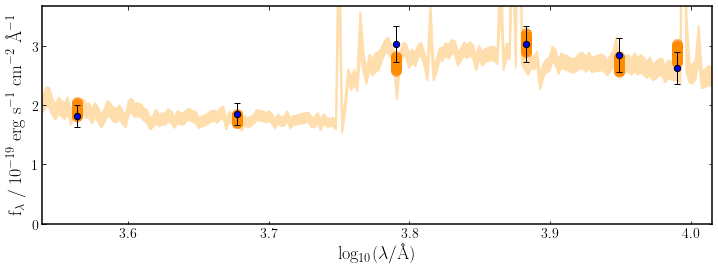

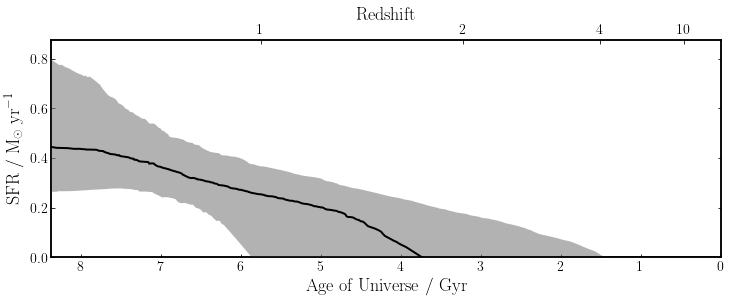

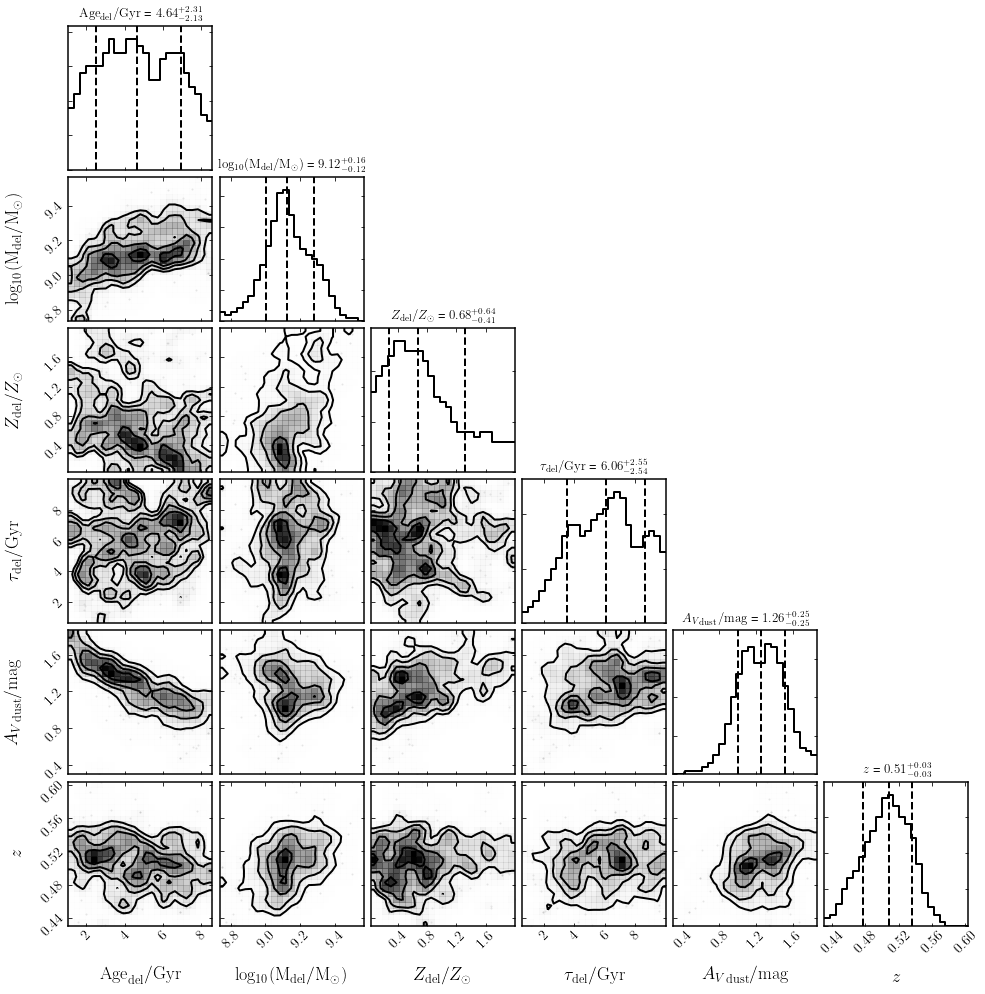

In [198]:
a = np.random.randint(10000)
print('v'+str(a))

fit = pipes.fit(galaxy, fit_instructions, run="v"+str(a))
fit.fit(verbose=False, n_live=100)
fig = fit.plot_spectrum_posterior(save=False, show=True)
fig = fit.plot_sfh_posterior(save=False, show=True)
fig = fit.plot_corner(save=False, show=True)


In [19]:
####ADDED
fit2 = pipes.fit(galaxy2, fit_instructions, run="2")
fit2.fit(verbose=True)


Bagpipes: fitting object 9463260011993


Completed in 18.4 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.301      0.745      1.261
exponential:age                1.688      3.752      5.803
exponential:massformed         8.168      8.670      9.112
exponential:metallicity        0.553      1.422      2.131
exponential:tau                3.255      6.134      8.648
redshift                       0.529      0.748      0.914




In [20]:
####ADDED
fit3 = pipes.fit(galaxy3, fit_instructions, run="3")
fit3.fit(verbose=True)


Bagpipes: fitting object 9463260011993


Completed in 69.5 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        0.056      0.189      0.447
exponential:age                3.452      4.803      5.813
exponential:massformed        11.127     11.223     11.306
exponential:metallicity        1.103      1.620      2.055
exponential:tau                0.461      0.638      0.775
redshift                       0.869      0.887      0.910




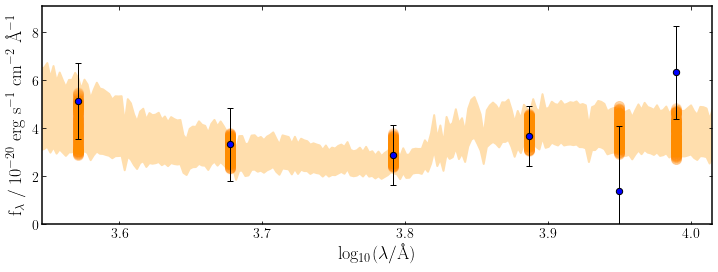

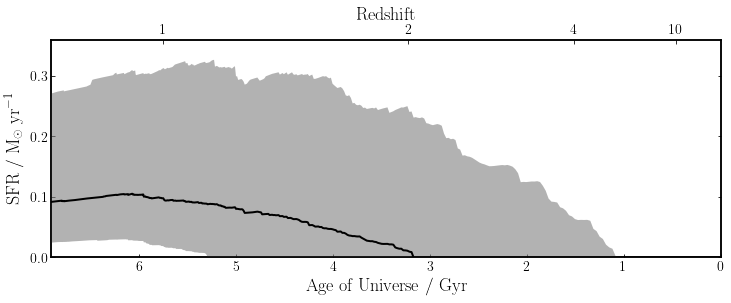

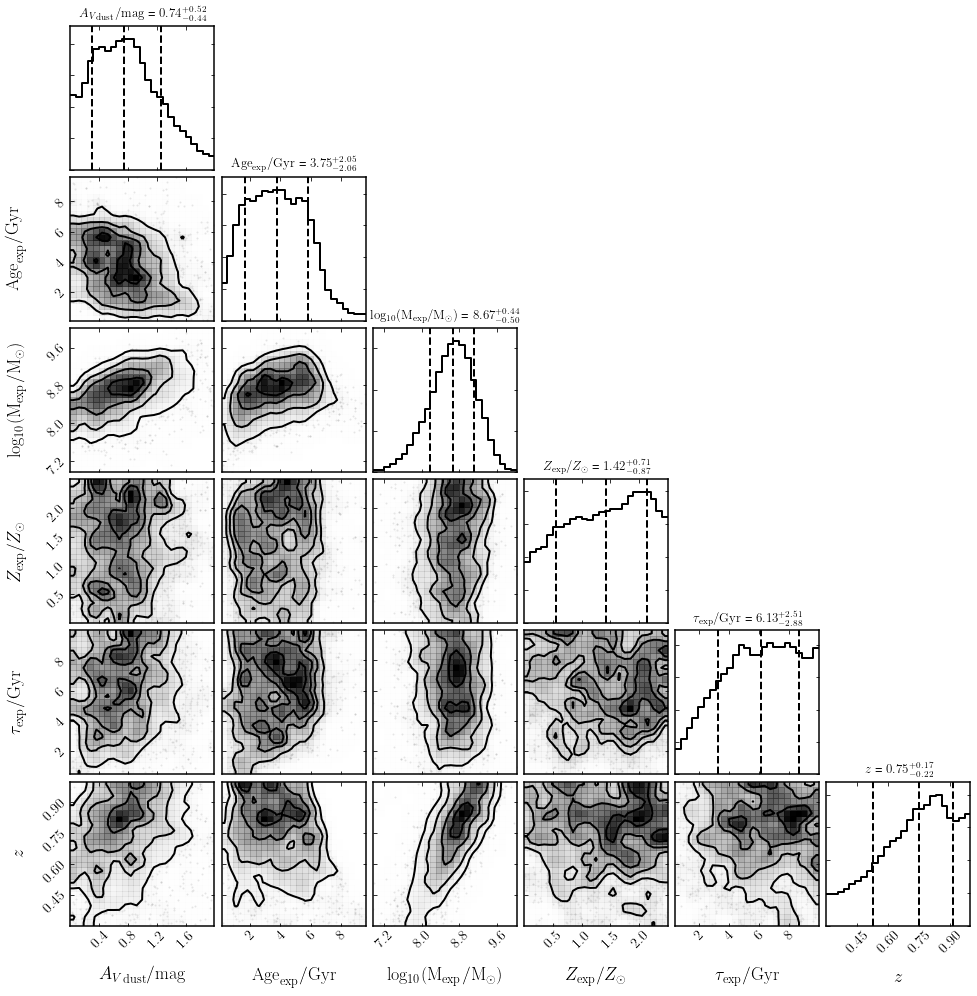

In [228]:
####ADDED
fig = fit2.plot_spectrum_posterior(save=False, show=True)
fig = fit2.plot_sfh_posterior(save=False, show=True)
fig = fit2.plot_corner(save=False, show=True)

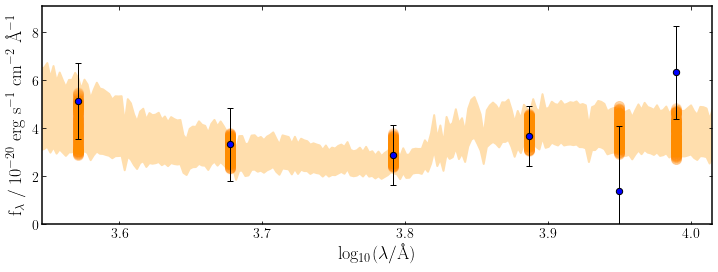

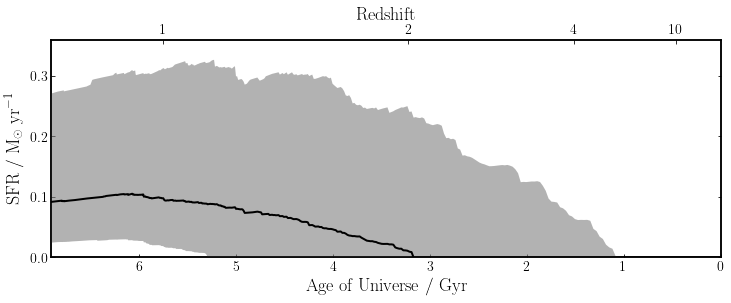

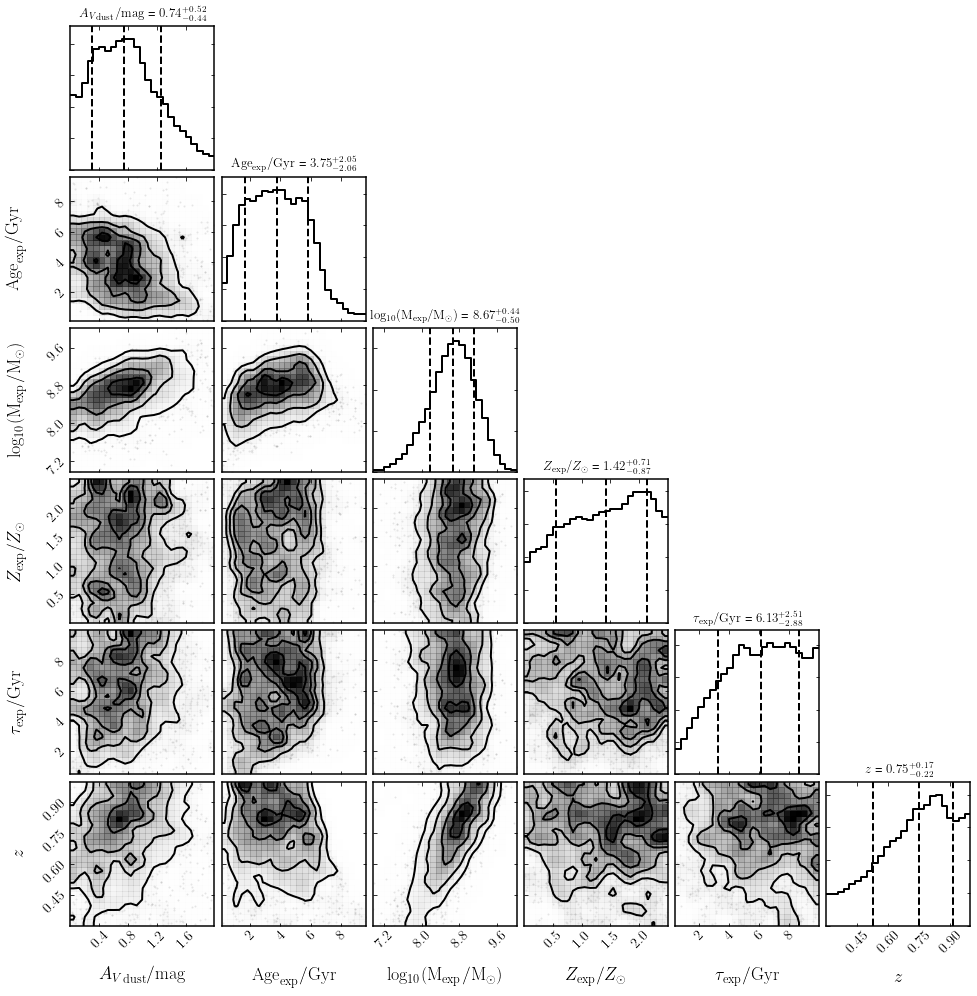

In [22]:
####ADDED
fig = fit2.plot_spectrum_posterior(save=False, show=True)
fig = fit2.plot_sfh_posterior(save=False, show=True)
fig = fit2.plot_corner(save=False, show=True)

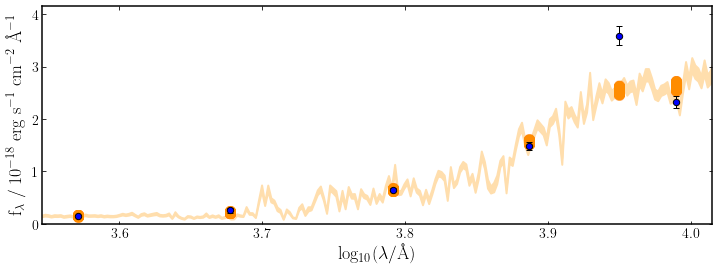

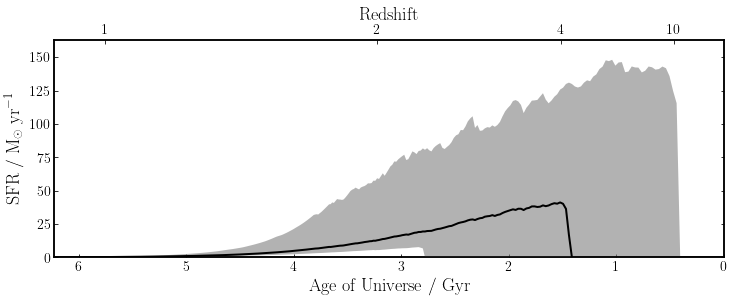

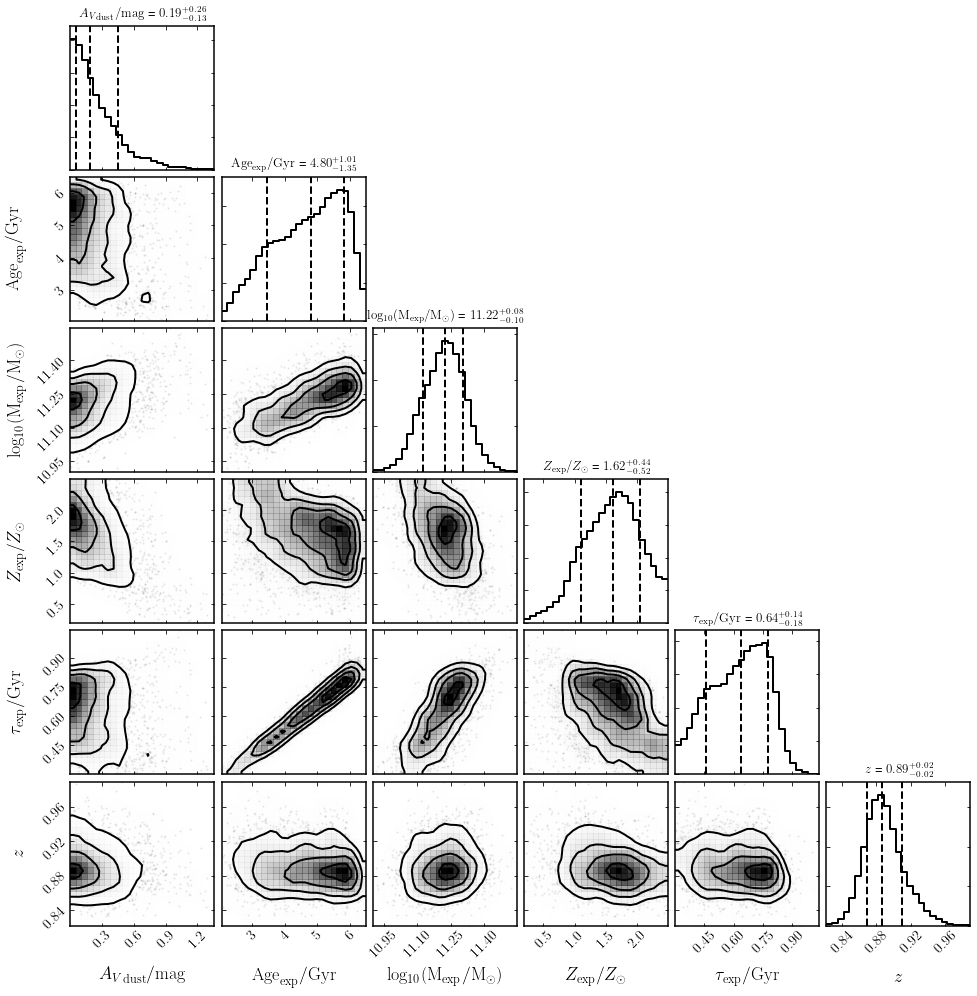

In [23]:
####ADDED
fig = fit3.plot_spectrum_posterior(save=False, show=True)
fig = fit3.plot_sfh_posterior(save=False, show=True)
fig = fit3.plot_corner(save=False, show=True)

### ### photometry data fit from example3

In [24]:
def load_goodss(ID):
    """ Load CANDELS GOODS South photometry from the Guo et al. (2013) catalogue. """

    # load up the relevant columns from the catalogue.
    cat = np.loadtxt("hlsp_candels_hst_wfc3_goodss-tot-multiband_f160w_v1-1photom_cat.txt",
                     usecols=(10, 13, 16, 19, 25, 28,
                                11, 14, 17, 20, 26, 29))
                     #usecols=(10, 13, 16, 19, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55,
                     #         11, 14, 17, 20, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56))
    
    # Find the correct row for the object we want.
    row = int(ID) - 1

    # Extract the object we want from the catalogue.
    fluxes = cat[row, :6]
    fluxerrs = cat[row, 6:]

    # Turn these into a 2D array.
    photometry = np.c_[fluxes, fluxerrs]

    # blow up the errors associated with any missing fluxes.
    for i in range(len(photometry)):
        if (photometry[i, 0] == 0.) or (photometry[i, 1] <= 0):
            photometry[i,:] = [0., 9.9*10**99.]
            
    # Enforce a maximum SNR of 20, or 10 in the IRAC channels.
    for i in range(len(photometry)):
        if i < 10:
            max_snr = 20.
            
        else:
            max_snr = 10.
        
        if photometry[i, 0]/photometry[i, 1] > max_snr:
            photometry[i, 1] = photometry[i, 0]/max_snr

    return photometry

[[6.987040e-02 7.049980e-03]
 [1.923840e-01 4.059220e-02]
 [8.308090e-01 4.154045e-02]
 [2.950840e+00 1.475420e-01]
 [7.377370e+00 3.688685e-01]
 [9.502210e+00 4.751105e-01]]


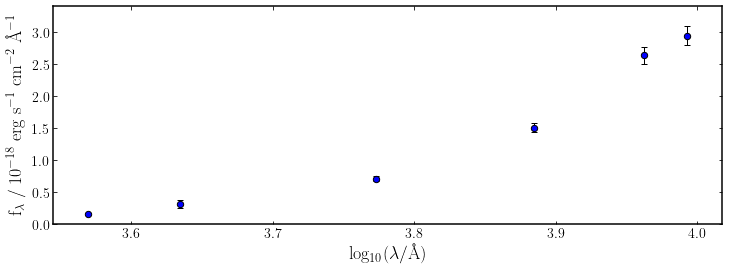

In [25]:
phot = load_goodss("17433")
print(phot)
galaxy = pipes.galaxy("17433", load_goodss, spectrum_exists=False, filt_list=goodss_filt_list[:6])
fig = galaxy.plot()

In [10]:
exp = {}                                  # Tau-model star-formation history component
exp["age"] = (0.1, 15.)                   # Vary age between 100 Myr and 15 Gyr. In practice 
                                          # the code automatically limits this to the age of
                                          # the Universe at the observed redshift.

exp["tau"] = (0.3, 10.)                   # Vary tau between 300 Myr and 10 Gyr
exp["massformed"] = (1., 15.)             # vary log_10(M*/M_solar) between 1 and 15
exp["metallicity"] = (0., 2.5)            # vary Z between 0 and 2.5 Z_oldsolar

dust = {}                                 # Dust component
dust["type"] = "Calzetti"                 # Define the shape of the attenuation curve
dust["Av"] = (0., 2.)                     # Vary Av between 0 and 2 magnitudes

fit_instructions = {}                     # The fit instructions dictionary
fit_instructions["redshift"] = (0.0, 10.0)       # Vary observed redshift from 0 to 10
fit_instructions["exponential"] = exp   
fit_instructions["dust"] = dust


In [215]:
fit = pipes.fit(galaxy, fit_instructions)

fit.fit(verbose=False)


Bagpipes: fitting object 0360920  


Completed in 65.1 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
dust:Av                        1.938      1.974      1.993
exponential:age                0.103      0.111      0.126
exponential:massformed        10.506     10.535     10.572
exponential:metallicity        2.167      2.368      2.463
exponential:tau                2.203      5.408      8.476




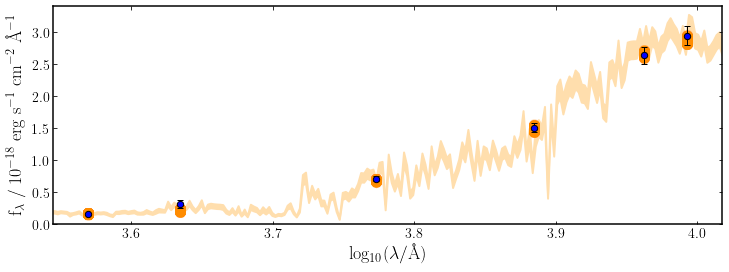

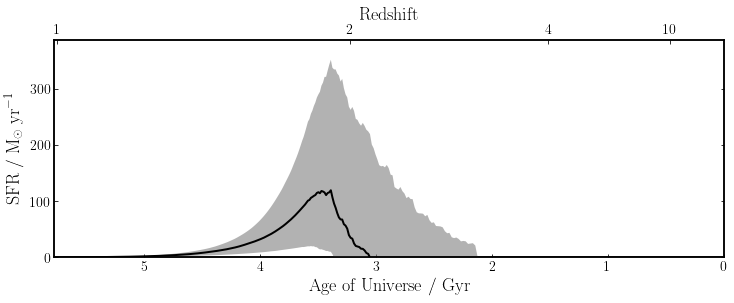

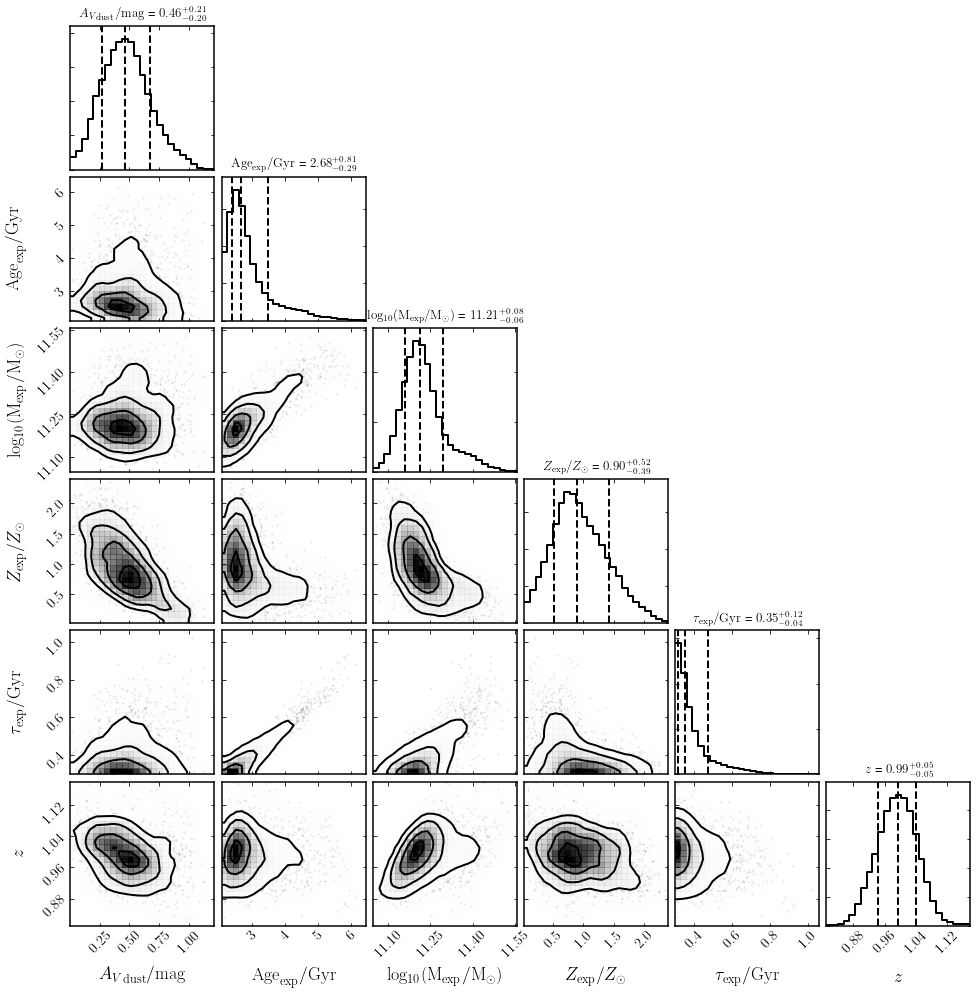

In [28]:
fig = fit.plot_spectrum_posterior(save=False, show=True)
fig = fit.plot_sfh_posterior(save=False, show=True)
fig = fit.plot_corner(save=False, show=True)

### fitting catalog

In [8]:
delayed = {}
delayed["age"] = (0.1, 14.)                 # time since first star forming
delayed["tau"] = (0.1, 10.0)                # timescale of star 🌟 forming
delayed["massformed"] = (6., 14.)             
delayed["metallicity"] = (0., 2.)   

dust = {}                                 # Dust component
dust["type"] = "Calzetti"                 # Define the shape of the attenuation curve
dust["Av"] = (0., 2.)                     # Vary Av between 0 and 2 magnitudes

fit_instructions = {}         
# The fit instructions dictionary
fit_instructions["redshift"] = (0., 5.)
fit_instructions["delayed"] = delayed
fit_instructions["dust"] = dust

In [14]:
IDs = [cat[100]['ID'],cat[101]['ID']]
redshifts = [0.02, 1.5238 ]
redshift_sigma = [0.01, 0.1332]
fit_cat = pipes.fit_catalogue(IDs, fit_instructions, load_gal, spectrum_exists=False,
                              cat_filt_list=filt_list, run="cat_v8")

fit_cat.fit(verbose=True,mpi_serial=True, n_live=100)

02101         ID   
---------
02101    
[[25.88523 ]
 [25.412458]
 [25.118246]
 [25.06622 ]
 [25.251022]
 [24.659119]]

Bagpipes: fitting object 02101    


Completed in 9.2 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
delayed:age                    0.854      1.575      2.677
delayed:massformed             7.534      7.717      7.932
delayed:metallicity            0.353      1.018      1.723
delayed:tau                    3.353      6.320      8.537
dust:Av                        0.063      0.217      0.462
redshift                       0.248      0.289      0.340




Bagpipes: 1 out of 2 objects completed.
02102         ID   
---------
02102    
[[29.38226 ]
 [25.669794]
 [24.899963]
 [24.782347]
 [24.567583]
 [24.580002]]

Bagpipes: fitting object 02102    


Completed in 16.0 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
delayed:age                    3.969      6.722      9.116
delayed:massformed             8.225      8.396      8.582
delayed:metallicity            0.032      0.081      0.168
delayed:tau                    0.957      3.131      7.165
dust:Av                        0.142      0.925      1.389
redshift                       0.192      0.224      0.256


Bagpipes: 2 out of 2 objects completed.


### prepare for fitting on Graham

cleaning of catalog:  cut_cat.py 

chop catalog into 10-20 pieces

In [71]:
cat_cosmos_tofit = Table.read('clauds_cat_v2020/COSMOS_deep_to_fit.fits')
cat_cosmos_tofit['ID'] = cat_cosmos_tofit['ID'].astype('i8')

n_each = int(len(cat_cosmos_tofit)/20)
print(n_each)

23909


In [89]:
for i in range(20):
    if i<19:
        cat_cosmos_tofit_cut = cat_cosmos_tofit[i*n_each: (i+1)*n_each]
    else:
        cat_cosmos_tofit_cut = cat_cosmos_tofit[i*n_each:]
    
    cat_cosmos_tofit_cut.write('clauds_cat_v2020/cosmos_to_fit_'+str(i+1)+'.fits',
                               overwrite=True)
    

In [73]:
cat_cosmos_tofit_rand = cat_cosmos_tofit[np.random.randint(len(cat_cosmos_tofit), size=400)]
cat_cosmos_tofit_rand.write('clauds_cat_v2020/COSMOS_deep_to_fit_'+'rand400'+'.fits', overwrite=True)

### combine catalogs for CANDELS

In [134]:
from astropy.table import hstack
cat_phot = Table.read('candels_pipes_test/hlsp_candels_hst_wfc3_cos-tot-multiband_f160w_v1_cat.fits')
cat_mass = Table.read('candels_pipes_test/hlsp_candels_hst_wfc3_cos_v1_mass_cat.fits')
cat_phys = Table.read('candels_pipes_test/hlsp_candels_hst_wfc3_cos_v1_physpar_cat.fits')
cat_photoz = Table.read('candels_pipes_test/hlsp_candels_hst_wfc3_cos_v1_photoz_cat.fits')

cat_tot =hstack([cat_phot,cat_mass, cat_phys,cat_photoz])
cat_tot.rename_column('ID_1','ID')
cat_tot.write('candels_pipes_test/hlsp_candels_cosmos_tot.fits', overwrite=True)

### cutting catalogs into small chunks

In [145]:
# cut candels_to_fit catalog into pieces each with 400 objects
cat_candels_tofit = Table.read('candels_pipes_test/candels_to_fit.fits')

# random cut
# cat_candels_tofit_rand = cat_candels_tofit[np.random.randint(len(cat_candels_tofit), size=100)]
# cat_candels_tofit_rand.write('candels_pipes_test/candels_to_fit_'+'rand_100gal'+'.fits', overwrite=True)
    
for i in range(5):
    cat_candels_tofit_rand = cat_candels_tofit[i*400: (i+1)*400]
    cat_candels_tofit_rand.write('candels_pipes_test/candels_to_fit_'+str(i)+'_'+'rand_400gal'+'.fits', overwrite=True)

matched catalog between CANDELS and CLAUDS-HSC v2  (in COSMOS)

In [82]:
# matchted (in topcat) between cosmos_to_fit and candels_to_fit
cat_v2_candels_tofit = Table.read('clauds_cat_v2020/COSMOS_deep_to_fit_candels_matched.fits')
print(len(cat_v2_candels_tofit))

# rename columns
cat_v2_candels_tofit.rename_column('ID_1','ID')
cat_v2_candels_tofit.rename_column('RA_1','RA')
cat_v2_candels_tofit.rename_column('DEC_1','DEC')

# random cut 
cat_v2_candels_tofit_rand = cat_v2_candels_tofit[np.random.randint(len(cat_v2_candels_tofit), size=200)]
cat_v2_candels_tofit_rand.write('clauds_cat_v2020/COSMOS_deep_to_fit_candels_matched_'+'rand_200gal'+'.fits', overwrite=True)


836


In [81]:
# v2 cat and matched cat
cat_v2_cosmos = Table.read('clauds_cat_v2020/COSMOS_deep_to_fit.fits')
cat_v2_candels_tofit_rand_old = Table.read('clauds_cat_v2020/COSMOS_deep_to_fit_candels_matched_'+'rand_200gal'+'.fits')

# choose the ones with matched ID in [v2 cat]
cat_v2_cosmos.add_index('ID')
cat_v2_candels_tofit_rand_new = cat_v2_cosmos[cat_v2_cosmos.loc_indices[np.array(cat_v2_candels_tofit_rand_old['ID'])]]
cat_v2_candels_tofit_rand_new.write('clauds_cat_v2020/COSMOS_deep_to_fit_candels_matched_'+'rand_200gals'+'.fits', overwrite=True)


### fitting CANDELS objects

In [155]:
import glob
from astropy.table import vstack

In [270]:
# stack candels pipes added catalogs (total 40*10*5 = 2000)
bands='6'

cat_stack = 0
slices_ = [0]
ranks = np.arange(0,10)

for slice_ in slices_:
    for rank in ranks:
        cat = Table.read('candels_pipes_test/candels_pipes_added_cats/candels_to_fit_'+str(slice_)+'_rand_400gal_pipes_added_'+bands+'band_'+str(rank)+'.fits')
        if slice_==0 and rank==0:
            cat_stack = cat
        else:
            cat_stack = vstack([cat_stack, cat])

cat_stack.write('candels_pipes_test/candels_pipes_added_'+bands+'_bands.fits', overwrite=True)



### compare 23band and 6band photometry

In [5]:
cat_candels_pipes_added = Table.read('candels_pipes_test/candels_pipes_added_23_bands.fits')
cat_candels_pipes_added_6band = Table.read('candels_pipes_test/candels_pipes_added_6_bands.fits')

cat_candels_pipes_added = Table.read('candels_pipes_test/candels_pipes_added_23_bands.fits')
cat_candels_pipes_added_6band = Table.read('candels_pipes_test/candels_pipes_added_6_bands.fits')

print(len(cat_candels_pipes_added),len(cat_candels_pipes_added_6band))

400 400


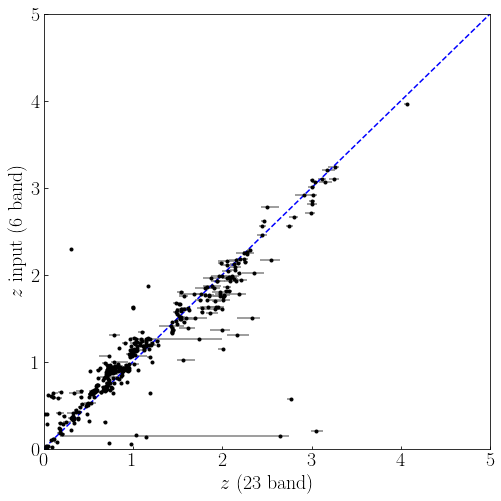

In [6]:
plt.figure(figsize = (8, 8))

z23 = cat_candels_pipes_added['redshift_50']
z23_low = cat_candels_pipes_added['redshift_16']
z23_high = cat_candels_pipes_added['redshift_84']

z6_input = cat_candels_pipes_added_6band['input_redshift']
print
markers, caps, bars = plt.errorbar(z23, z6_input,
                                   xerr = [z23 - z23_low,z23_high-z23],
                                   linestyle="None",
                                   fmt='.k',ecolor='gray')

plt.plot([0,14],[0,14],color='b',linestyle='--')
plt.xlim([0,5])
plt.ylim([0,5])
plt.xlabel(r'$z$ (23 band)',fontsize=20)
plt.ylabel(r'$z$ input (6 band)',fontsize=20)
plt.show()

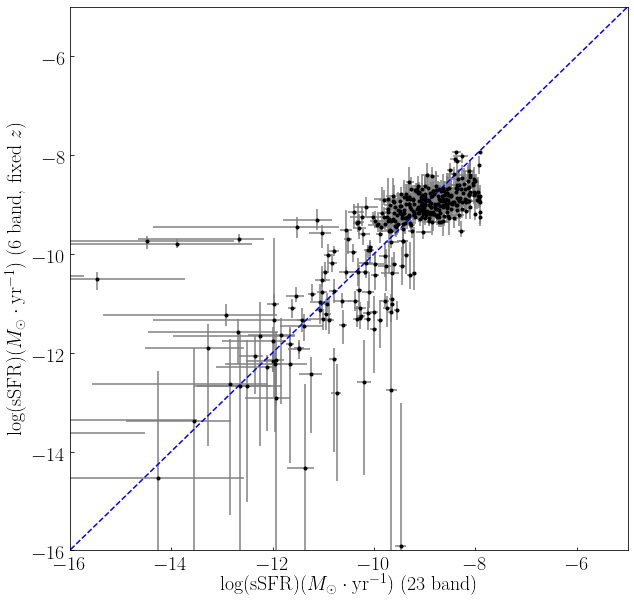

In [30]:
plt.figure(figsize = (10, 10))

m23 = cat_candels_pipes_added['ssfr_50']
m23_low = cat_candels_pipes_added['ssfr_16']
m23_high = cat_candels_pipes_added['ssfr_84']

m6 = cat_candels_pipes_added_6band['ssfr_50']
m6_low = cat_candels_pipes_added_6band['ssfr_16']
m6_high = cat_candels_pipes_added_6band['ssfr_84']

markers, caps, bars = plt.errorbar(m23, m6,
                                   xerr = [m23 - m23_low,m23_high-m23],
                                   yerr = [m6 - m6_low,m6_high-m6],linestyle="None",
                                         fmt='.k',ecolor='gray')

plt.plot([-20,20],[-20,20],color='b',linestyle='--')
plt.xlim([-16,-5])
plt.ylim([-16,-5])
plt.xlabel(r'$\log (\mathrm{sSFR}) (M_\odot\cdot\mathrm{yr}^{-1})$ (23 band)',fontsize=20)
plt.ylabel(r'$\log (\mathrm{sSFR}) (M_\odot\cdot\mathrm{yr}^{-1})$ (6 band, fixed $z$)',fontsize=20)
plt.show()

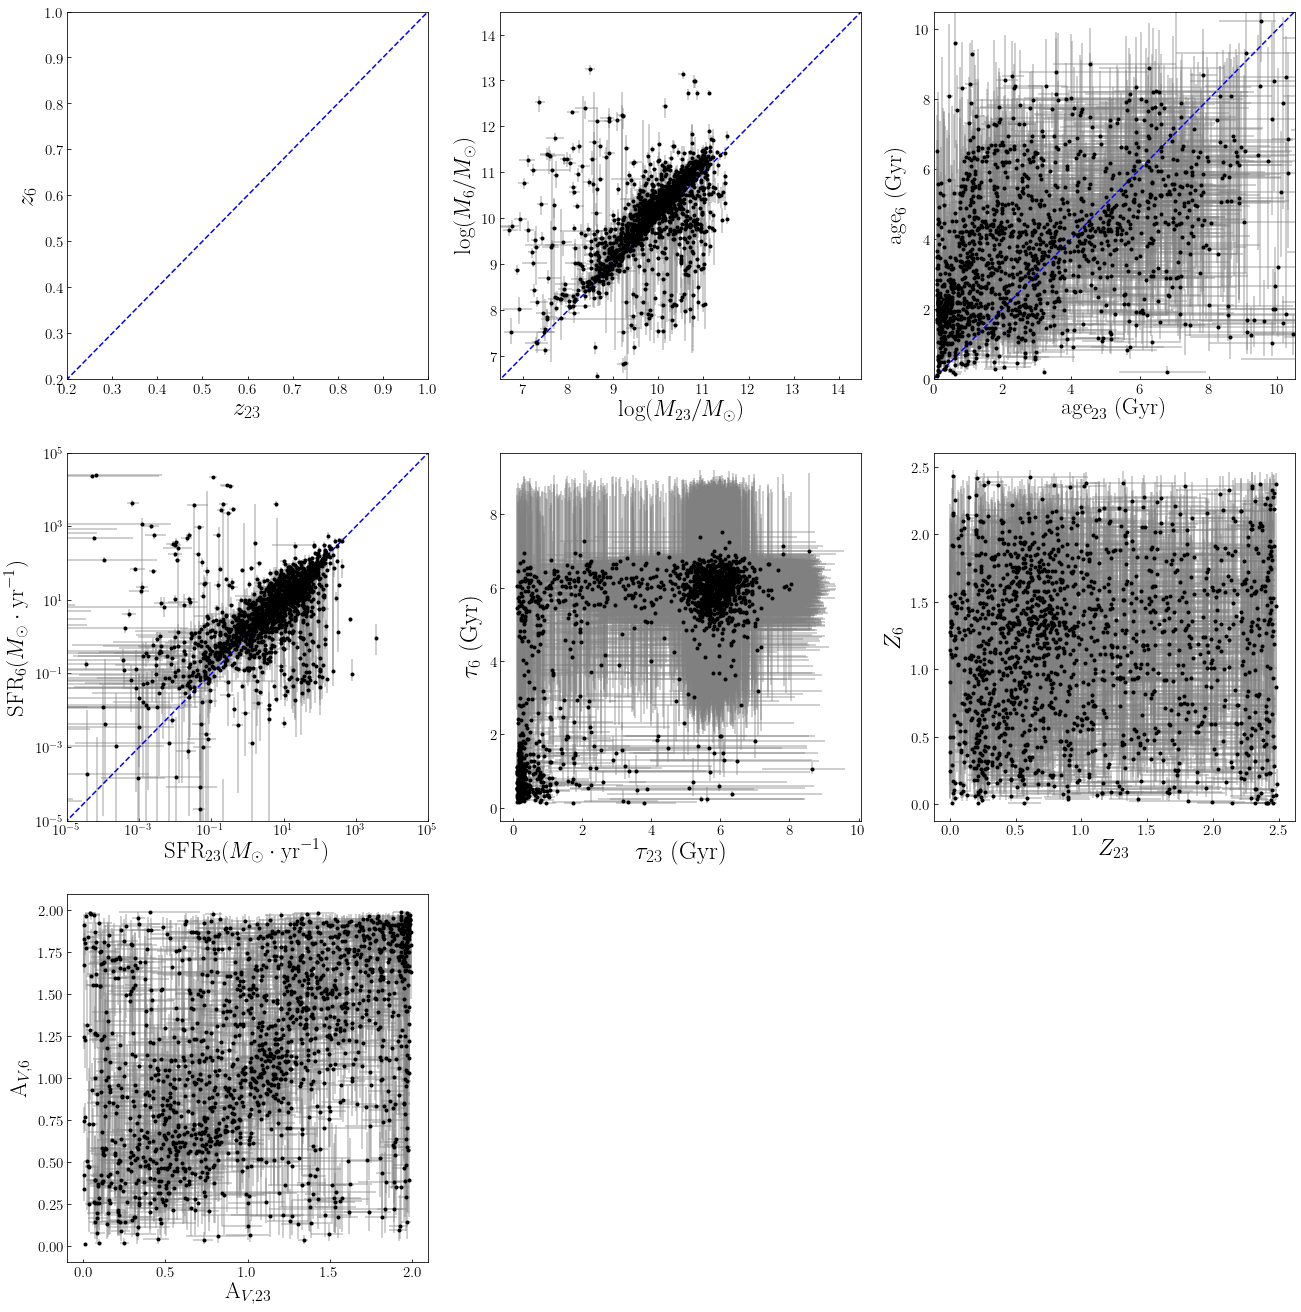

In [267]:
# z, mass, age, sfr, tau, metallicity, Av
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
fig, axs = plt.subplots(3, 3, figsize=(22,23))

# z
# z_23 = cat_candels_pipes_added['redshift_50']
# z_23_low = cat_candels_pipes_added['redshift_16']
# z_23_high = cat_candels_pipes_added['redshift_84']

# z_6 = cat_candels_pipes_added_6band['redshift_50']
# z_6_low = cat_candels_pipes_added_6band['redshift_16']
# z_6_high = cat_candels_pipes_added_6band['redshift_84']

# markers, caps, bars = axs[0][0].errorbar(z_23, z_6,
#                                          xerr = [z_23 - z_23_low,z_23_high-z_23],
#                                          yerr = [z_6 - z_6_low,z_6_high-z_6],linestyle="None",
#                                          fmt='ok',ecolor='gray')
# [bar.set_alpha(0.5) for bar in bars]

axs[0][0].plot([0,1.5],[0,1.5],color='b',linestyle='--')
axs[0][0].set_xlim([0.2,1])
axs[0][0].set_ylim([0.2,1])
axs[0][0].set_xlabel(r'$z_\mathrm{23}$',fontsize=25)
axs[0][0].set_ylabel(r'$z_\mathrm{6}$',fontsize=25)

# mass
m_23 = cat_candels_pipes_added['stellar_mass_50']
m_23_low = cat_candels_pipes_added['stellar_mass_16']
m_23_high = cat_candels_pipes_added['stellar_mass_84']

m_6 = cat_candels_pipes_added_6band['stellar_mass_50']
m_6_low = cat_candels_pipes_added_6band['stellar_mass_16']
m_6_high = cat_candels_pipes_added_6band['stellar_mass_84']

markers, caps, bars = axs[0][1].errorbar(m_23, m_6,
                                         xerr = [m_23 - m_23_low,m_23_high-m_23],
                                         yerr = [m_6 - m_6_low,m_6_high-m_6],linestyle="None",
                                         fmt='.k',ecolor='gray')
[bar.set_alpha(0.5) for bar in bars]

axs[0][1].plot([0,15],[0,15],color='b',linestyle='--')
axs[0][1].set_xlim([6.5,14.5])
axs[0][1].set_ylim([6.5,14.5])
axs[0][1].set_xlabel(r'$\log (M_\mathrm{23}/M_\odot)$',fontsize=23)
axs[0][1].set_ylabel(r'$\log (M_\mathrm{6}/M_\odot)$',fontsize=23)

# age
age_23 = cat_candels_pipes_added['delayed:age_50']
age_23_low = cat_candels_pipes_added['delayed:age_16']
age_23_high = cat_candels_pipes_added['delayed:age_84']

age_6 = cat_candels_pipes_added_6band['delayed:age_50']
age_6_low = cat_candels_pipes_added_6band['delayed:age_16']
age_6_high = cat_candels_pipes_added_6band['delayed:age_84']

markers, caps, bars = axs[0][2].errorbar(age_23, age_6, 
                                         xerr = [age_23 - age_23_low,age_23_high-age_23],
                                         yerr = [age_6 - age_6_low,age_6_high-age_6],linestyle="None",
                                         fmt='.k',ecolor='gray')
[bar.set_alpha(0.5) for bar in bars]

axs[0][2].plot([0,11],[0,11],color='b',linestyle='--')
axs[0][2].set_xlim([0,10.5])
axs[0][2].set_ylim([0,10.5])
axs[0][2].set_xlabel(r'$\mathrm{age}_\mathrm{23}$ (Gyr)',fontsize=23)
axs[0][2].set_ylabel(r'$\mathrm{age}_\mathrm{6}$ (Gyr)',fontsize=23)

# sfr
sfr_23 = cat_candels_pipes_added['sfr_50']
sfr_23_low = cat_candels_pipes_added['sfr_16']
sfr_23_high = cat_candels_pipes_added['sfr_84']

sfr_6 = cat_candels_pipes_added_6band['sfr_50']
sfr_6_low = cat_candels_pipes_added_6band['sfr_16']
sfr_6_high = cat_candels_pipes_added_6band['sfr_84']

markers, caps, bars = axs[1][0].errorbar(sfr_23, sfr_6, 
                                         xerr = [sfr_23 - sfr_23_low,sfr_23_high-sfr_23],
                                         yerr = [sfr_6 - sfr_6_low,sfr_6_high-sfr_6],linestyle="None",
                                         fmt='.k',ecolor='gray')
[bar.set_alpha(0.5) for bar in bars]

axs[1][0].set_xscale('log')
axs[1][0].set_yscale('log')
axs[1][0].plot([1e-6,1e6],[1e-6,1e6],color='b',linestyle='--')
axs[1][0].set_xlim([1e-5,1e5])
axs[1][0].set_ylim([1e-5,1e5])
axs[1][0].set_xlabel(r'$\mathrm{SFR}_\mathrm{23} (M_\odot\cdot \mathrm{yr}^{-1})$',fontsize=23)
axs[1][0].set_ylabel(r'$\mathrm{SFR}_\mathrm{6} (M_\odot\cdot \mathrm{yr}^{-1})$',fontsize=23)

# tau
tau_23 = cat_candels_pipes_added['delayed:tau_50']
tau_23_low = cat_candels_pipes_added['delayed:tau_16']
tau_23_high = cat_candels_pipes_added['delayed:tau_84']

tau_6 = cat_candels_pipes_added_6band['delayed:tau_50']
tau_6_low = cat_candels_pipes_added_6band['delayed:tau_16']
tau_6_high = cat_candels_pipes_added_6band['delayed:tau_84']

markers, caps, bars = axs[1][1].errorbar(tau_23, tau_6, 
                                         xerr = [tau_23 - tau_23_low,tau_23_high-tau_23],
                                         yerr = [tau_6 - tau_6_low,tau_6_high-tau_6],linestyle="None",
                                         fmt='.k',ecolor='gray')
[bar.set_alpha(0.5) for bar in bars]

axs[1][1].set_xlabel(r'$\tau_\mathrm{23}$ (Gyr)',fontsize=25)
axs[1][1].set_ylabel(r'$\tau_\mathrm{6}$ (Gyr)',fontsize=25)

# metallicity
metal_23 = cat_candels_pipes_added['delayed:metallicity_50']
metal_23_low = cat_candels_pipes_added['delayed:metallicity_16']
metal_23_high = cat_candels_pipes_added['delayed:metallicity_84']

metal_6 = cat_candels_pipes_added_6band['delayed:metallicity_50']
metal_6_low = cat_candels_pipes_added_6band['delayed:metallicity_16']
metal_6_high = cat_candels_pipes_added_6band['delayed:metallicity_84']

markers, caps, bars = axs[1][2].errorbar(metal_23, metal_6, 
                                         xerr = [metal_23 - metal_23_low,metal_23_high-metal_23],
                                         yerr = [metal_6 - metal_6_low,metal_6_high-metal_6],linestyle="None",
                                         fmt='.k',ecolor='gray')
[bar.set_alpha(0.5) for bar in bars]

axs[1][2].set_xlabel(r'$Z_\mathrm{23}$',fontsize=23)
axs[1][2].set_ylabel(r'$Z_\mathrm{6}$',fontsize=23)

# Av
av_23 = cat_candels_pipes_added['dust:Av_50']
av_23_low = cat_candels_pipes_added['dust:Av_16']
av_23_high = cat_candels_pipes_added['dust:Av_84']

av_6 = cat_candels_pipes_added_6band['dust:Av_50']
av_6_low = cat_candels_pipes_added_6band['dust:Av_16']
av_6_high = cat_candels_pipes_added_6band['dust:Av_84']

markers, caps, bars = axs[2][0].errorbar(av_23, av_6,
                                         xerr = [av_23 - av_23_low, av_23_high-av_23],
                                         yerr = [av_6 - av_6_low, av_6_high-av_6],linestyle="None",
                                         fmt='.k',ecolor='gray')
[bar.set_alpha(0.5) for bar in bars]
axs[2][0].set_xlabel(r'$\mathrm{A}_{V,\mathrm{23}}$',fontsize=23)
axs[2][0].set_ylabel(r'$\mathrm{A}_{V,\mathrm{6}}$',fontsize=23)

fig.delaxes(axs[2][1])
fig.delaxes(axs[2][2])
plt.savefig('/Users/lejay/Desktop/candels_pipes_compare_23_6.pdf')


Text(0, 0.5, '$\\mathrm{age}_\\mathrm{6}$')

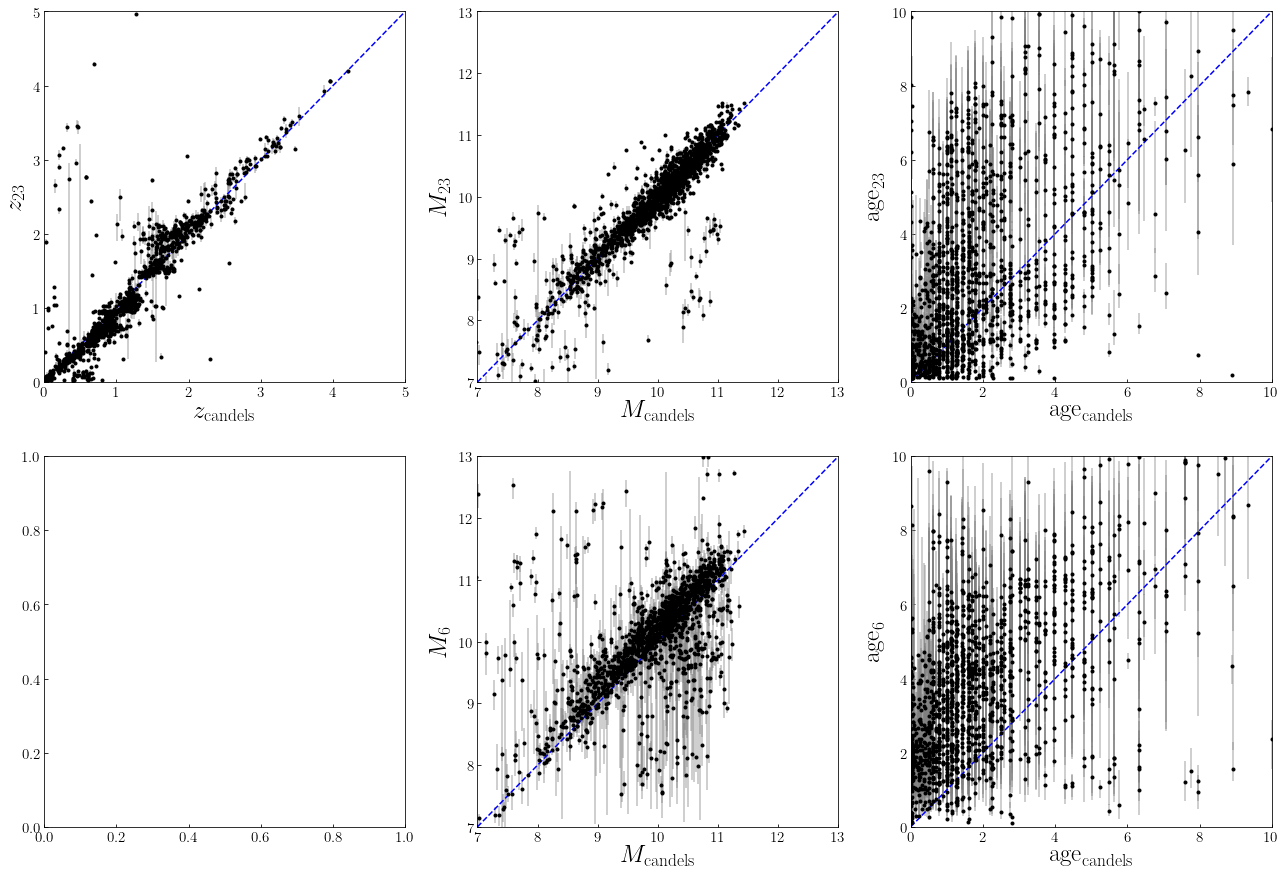

In [266]:
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=15), plt.rc('ytick', labelsize=15)
fig, axs = plt.subplots(2, 3, figsize=(22,15))

# z
z_in = cat_candels_pipes_added['zbest']

z_23 = cat_candels_pipes_added['redshift_50']
z_23_low = cat_candels_pipes_added['redshift_16']
z_23_high = cat_candels_pipes_added['redshift_84']

# z_6 = cat_candels_pipes_added_6band['redshift_50']
# z_6_low = cat_candels_pipes_added_6band['redshift_16']
# z_6_high = cat_candels_pipes_added_6band['redshift_84']

markers, caps, bars = axs[0][0].errorbar(z_in, z_23,
                                         yerr = [z_23 - z_23_low,z_23_high-z_23],linestyle="None",
                                         fmt='.k',ecolor='gray')
[bar.set_alpha(0.5) for bar in bars]

axs[0][0].plot([0,5],[0,5],color='b',linestyle='--')
axs[0][0].set_xlim([0,5])
axs[0][0].set_ylim([0,5])
axs[0][0].set_xlabel(r'$z_\mathrm{candels}$',fontsize=25)
axs[0][0].set_ylabel(r'$z_\mathrm{23}$',fontsize=25)

# markers, caps, bars = axs[1][0].errorbar(z_in, z_6,
#                                          yerr = [z_6 - z_6_low,z_6_high-z_6],linestyle="None",
#                                          fmt='ok',ecolor='gray')
# [bar.set_alpha(0.5) for bar in bars]

# axs[1][0].plot([0,5],[0,5],color='b',linestyle='--')
# axs[1][0].set_xlim([0,5])
# axs[1][0].set_ylim([0,5])
# axs[1][0].set_xlabel(r'$z_\mathrm{candels}$',fontsize=25)
# axs[1][0].set_ylabel(r'$z_\mathrm{6}$',fontsize=25)


# mass
m_in = cat_candels_pipes_added['M_6_tau']

m_23 = cat_candels_pipes_added['stellar_mass_50']
m_23_low = cat_candels_pipes_added['stellar_mass_16']
m_23_high = cat_candels_pipes_added['stellar_mass_84']

m_6 = cat_candels_pipes_added_6band['stellar_mass_50']
m_6_low = cat_candels_pipes_added_6band['stellar_mass_16']
m_6_high = cat_candels_pipes_added_6band['stellar_mass_84']

markers, caps, bars = axs[0][1].errorbar(m_in, m_23,
                                         yerr = [m_23 - m_23_low,m_23_high-m_23],linestyle="None",
                                         fmt='.k',ecolor='gray')
[bar.set_alpha(0.5) for bar in bars]

axs[0][1].plot([7,13],[7,13],color='b',linestyle='--')
axs[0][1].set_xlim([7,13])
axs[0][1].set_ylim([7,13])
axs[0][1].set_xlabel(r'$M_\mathrm{candels}$',fontsize=25)
axs[0][1].set_ylabel(r'$M_\mathrm{23}$',fontsize=25)

markers, caps, bars = axs[1][1].errorbar(m_in, m_6,
                                         yerr = [m_6 - m_6_low,m_6_high-m_6],linestyle="None",
                                         fmt='.k',ecolor='gray')
[bar.set_alpha(0.5) for bar in bars]

axs[1][1].plot([7,13],[7,13],color='b',linestyle='--')
axs[1][1].set_xlim([7,13])
axs[1][1].set_ylim([7,13])
axs[1][1].set_xlabel(r'$M_\mathrm{candels}$',fontsize=25)
axs[1][1].set_ylabel(r'$M_\mathrm{6}$',fontsize=25)

# age
age_in = 10**cat_candels_pipes_added['age_6a_tau']/1e9

age_23 = cat_candels_pipes_added['delayed:age_50']
age_23_low = cat_candels_pipes_added['delayed:age_16']
age_23_high = cat_candels_pipes_added['delayed:age_84']

age_6 = cat_candels_pipes_added_6band['delayed:age_50']
age_6_low = cat_candels_pipes_added_6band['delayed:age_16']
age_6_high = cat_candels_pipes_added_6band['delayed:age_84']

markers, caps, bars = axs[0][2].errorbar(age_in, age_23,
                                         yerr = [age_23 - age_23_low,age_23_high-age_23],linestyle="None",
                                         fmt='.k',ecolor='gray')
[bar.set_alpha(0.5) for bar in bars]

axs[0][2].plot([0,13],[0,13],color='b',linestyle='--')
axs[0][2].set_xlim([0,10])
axs[0][2].set_ylim([0,10])
axs[0][2].set_xlabel(r'$\mathrm{age}_\mathrm{candels}$',fontsize=25)
axs[0][2].set_ylabel(r'$\mathrm{age}_\mathrm{23}$',fontsize=25)

markers, caps, bars = axs[1][2].errorbar(age_in, age_6,
                                         yerr = [age_6 - age_6_low,age_6_high-age_6],linestyle="None",
                                         fmt='.k',ecolor='gray')
[bar.set_alpha(0.5) for bar in bars]

axs[1][2].plot([0,13],[0,13],color='b',linestyle='--')
axs[1][2].set_xlim([0,10])
axs[1][2].set_ylim([0,10])
axs[1][2].set_xlabel(r'$\mathrm{age}_\mathrm{candels}$',fontsize=25)
axs[1][2].set_ylabel(r'$\mathrm{age}_\mathrm{6}$',fontsize=25)

### UVJ diagram

needs full_catalog=True

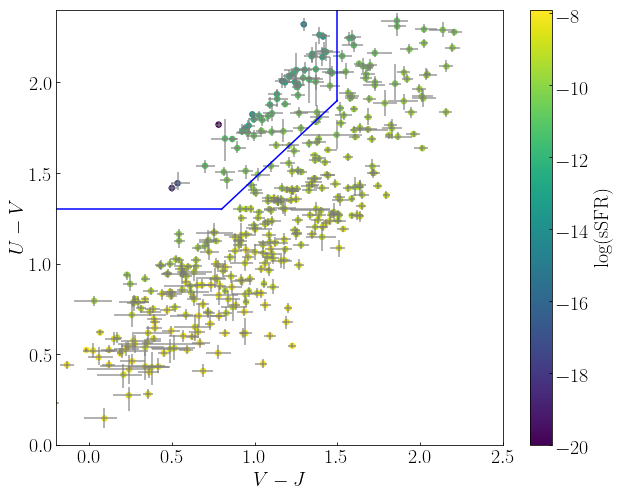

In [20]:
ax = plt.figure(figsize = (10, 8))

uv = cat_candels_pipes_added['UV_colour_50']
uv_low = cat_candels_pipes_added['UV_colour_16']
uv_high = cat_candels_pipes_added['UV_colour_84']

vj = cat_candels_pipes_added['VJ_colour_50']
vj_low = cat_candels_pipes_added['VJ_colour_16']
vj_high = cat_candels_pipes_added['VJ_colour_84']

ssfr = np.array(cat_candels_pipes_added['ssfr_50'])

cmap = matplotlib.cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin=min(ssfr), vmax=max(ssfr))


markers, caps, bars = plt.errorbar(x=vj, y=uv,
                                   xerr = [vj - vj_low, vj_high-vj],
                                   yerr = [uv - uv_low, uv_high-uv],linestyle="None", 
                                   fmt='ok',ecolor='gray',alpha=0.01)
[bar.set_alpha(0.8) for bar in bars]

plt.scatter(vj,uv,c=ssfr,s=30,vmin=-20)

plt.plot([-0.2,0.8],[1.3,1.3],c='b')
plt.plot([0.8,1.5],[1.3,1.9],c='b')
plt.plot([1.5,1.5],[1.9,2.5],c='b')

plt.xlim([-0.2,2.5])
plt.ylim([0,2.4])
cbar = plt.colorbar()
cbar.set_label(r'$\log$(sSFR)',fontsize=20)

plt.xlabel(r'$V-J$ ',fontsize=20)
plt.ylabel(r'$U-V$',fontsize=20)
plt.show()


/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


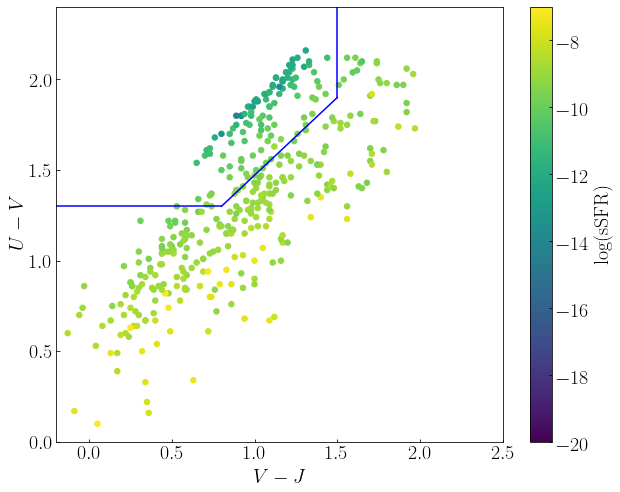

In [21]:
cat_candels_phys_pipes_added = Table.read('candels_pipes_test/candels_pipes_phys_added_23_bands.fits')

ax = plt.figure(figsize = (10, 8))

uv = cat_candels_phys_pipes_added['UMag_6a_tau'] - cat_candels_phys_pipes_added['VMag_6a_tau']
vj = cat_candels_phys_pipes_added['VMag_6a_tau'] - cat_candels_phys_pipes_added['JMag_6a_tau']

sfr = cat_candels_phys_pipes_added['SFR_6a_tau']
M = 10**cat_candels_phys_pipes_added['M_6_tau_1']
ssfr = np.log10(sfr/M)

cmap = matplotlib.cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(vmin=min(ssfr), vmax=max(ssfr))
[bar.set_alpha(0.8) for bar in bars]

plt.scatter(vj,uv,c=ssfr,s=30,vmin=-20)

plt.plot([-0.2,0.8],[1.3,1.3],c='b')
plt.plot([0.8,1.5],[1.3,1.9],c='b')
plt.plot([1.5,1.5],[1.9,2.5],c='b')

plt.xlim([-0.2,2.5])
plt.ylim([0,2.4])
cbar = plt.colorbar()
cbar.set_label(r'$\log$(sSFR)',fontsize=20)

plt.xlabel(r'$V-J$ ',fontsize=20)
plt.ylabel(r'$U-V$',fontsize=20)
plt.show()


In [75]:
a = np.array([np.nan,1,1,2,3])

In [78]:
a[~np.isnan(a)]

array([1., 1., 2., 3.])